# LAP3. El pie derecho no se levanta completamente.

Continuando con la categoría que valora la longitud y altura del paso en la escala de Tinetti,
la cuestión tratada en esta *notebook* como un problema de clasificación binaria consiste en
determinar si el pie derecho se levanta completamente con el paso durante la marcha (normal)
o no (patológica). Para ello, se ha utilizado un subconjunto de datos que contiene las 48
grabaciones normales (norm), etiquetadas como 0, y las 20 capturas de movimiento en las
que se ha simulado esta alteración de la marcha (*lap3*), etiquetadas como 1.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import joblib

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os
import math
import time
import itertools
import shutil
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from column_selector import ColumnsSelector


# to make this notebook's output stable across runs
RANDOM_SEED = 42
TEST_SIZE = 0.33
np.random.seed(RANDOM_SEED)
POSITIVE_CLASS = 'lap3'
dataset_path = "D:/dataset/optitrack/"


#http://aeturrell.com/2018/01/31/publication-quality-plots-in-python/
plt.style.use('../plot_style.txt')


colors =["cornflowerblue", "lightcoral"]

In [2]:
def save_fig(fig_id, out_dir, tight_layout=True, fig_extension="png", resolution=1200):
    path = os.path.join(out_dir, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
#http://aeturrell.com/2018/01/31/publication-quality-plots-in-python/

## Carga de datos

**Carga espaciotemporales y borra características correlacionadas**

In [3]:
# Características espaciotemporales correlacionadas
st_correlated = ['com_horizontal_displacement_norm', 'speed_norm', 'right_swing_phase_duration_norm', 
                 'left_swing_phase_duration_norm',
'left_stance_phase_duration_norm', 'right_stance_phase_duration_norm', 'left_double_support_duration_norm',
 'right_double_support_duration_norm'
]

In [4]:
spatiotemporal = pd.read_csv(os.path.join(dataset_path, 'spatiotemporal.csv'))
spatiotemporal.drop(st_correlated, axis=1, inplace=True)
spatiotemporal.head(2)

,subject,record,right_stride_length_norm,left_stride_length_norm,right_step_length_norm,left_step_length_norm,base_of_support_norm,right_heel_height_norm,left_heel_height_norm,right_toe_height_norm,...,right_stride_duration,left_stride_duration,right_double_support_percent,left_double_support_percent,right_step_angle,left_step_angle,right_toe_off_angle,left_toe_off_angle,right_strike_angle,left_strike_angle
0,subject_01,rec_01,1.183,1.199,0.581,0.641,0.145,0.862,0.861,0.348,...,1.37,1.36,24.09,23.59,7.59,23.55,21.03,21.15,68.97,68.85
1,subject_01,rec_02,1.208,1.219,0.575,0.658,0.141,0.866,0.875,0.353,...,1.32,1.31,24.70,24.39,6.51,19.06,25.02,18.65,64.98,71.35


**Carga kinematics y trata características correlacionadas**

In [5]:
kin_correlated_opp_foot = [('left_pelvis_tilt_Range', 'right_pelvis_tilt_Range'),
 ('left_pelvis_tilt_Stride_End', 'right_pelvis_tilt_Stride_End'),
 ('left_pelvis_rotation_Range', 'right_pelvis_rotation_Range'),
 ('left_pelvis_tilt_Max', 'right_pelvis_tilt_Max'),
 ('left_pelvis_tilt_Stride_Start', 'right_pelvis_tilt_Stride_Start'),
 ('left_pelvis_tilt_Min', 'right_pelvis_tilt_Min'),
 ('left_pelvis_obliquity_Range', 'right_pelvis_obliquity_Range'),
 ('left_pelvis_tilt_Mean', 'right_pelvis_tilt_Mean')]

In [6]:
def spearm_corr_pairs (data, thr):
    corr = data.corr(method='spearman')
    corr = corr.unstack()
    so = corr[corr > thr]
    so = set(tuple(sorted(t)) for t in so.index.tolist())
    so = [x for x in so if x[0] != x[1]]
    return so

In [7]:
kinematics = pd.read_csv(os.path.join(dataset_path, 'kinematics.csv'))    
kinematics.head(2)

,subject,record,right_pelvis_tilt_Min,right_pelvis_tilt_Max,right_pelvis_tilt_Range,right_pelvis_tilt_Mean,right_pelvis_tilt_Stride_Start,right_pelvis_tilt_Stride_End,right_pelvis_tilt_Swing_Angle,left_pelvis_tilt_Min,...,right_foot_rotation_Stride_Start,right_foot_rotation_Stride_End,right_foot_rotation_Swing_Angle,left_foot_rotation_Min,left_foot_rotation_Max,left_foot_rotation_Range,left_foot_rotation_Mean,left_foot_rotation_Stride_Start,left_foot_rotation_Stride_End,left_foot_rotation_Swing_Angle
0,subject_01,rec_01,7.585,11.670,4.085,9.747,10.795,9.916,9.740,7.541,...,-17.899,-13.335,-5.208,-9.810,16.455,26.265,2.786,-4.685,-5.102,13.976
1,subject_01,rec_02,7.857,12.011,4.154,9.969,11.039,10.125,9.963,7.867,...,-15.165,-8.896,-3.928,-8.544,18.301,26.846,3.412,-1.125,-1.251,14.083


In [8]:
summary = pd.read_excel(os.path.join(dataset_path, 'summary.xlsx'), usecols= ["subject", "record", "label"])
summary.head(2)

,subject,record,label
0,subject_01,rec_01,norm
1,subject_01,rec_02,norm


Filtra el conjunto de datos para quedarnos solo con las grabaciones deseadas:

In [9]:
discarded_records = [
    {'subject': 'subject_07', 'record': 'rec_03'},
    {'subject': 'subject_10', 'record': 'rec_05'},
]

for rec in discarded_records:
    print(rec['subject'])
    kinematics = kinematics.drop(kinematics[(kinematics.subject == rec['subject']) 
                                            & (kinematics.record == rec['record'])].index)
    spatiotemporal = spatiotemporal.drop(spatiotemporal[(spatiotemporal.subject == rec['subject']) 
                                            & (spatiotemporal.record == rec['record'])].index)

subject_07
subject_10


In [10]:
normal_records = [
    "rec_01", 
    "rec_02", 
    "rec_03", 
    "rec_04",  
    "rec_05"
]

pathological_records = [
    "rec_10",
    "rec_11"
]

labels_dict = {'norm':0} 
labels_dict[POSITIVE_CLASS] = 1

spatiotemporal = spatiotemporal.drop(spatiotemporal[~(spatiotemporal.record.isin(normal_records + pathological_records))].index)
kinematics = kinematics.drop(kinematics[~(kinematics.record.isin(normal_records + pathological_records))].index)

Borra variables cinemáticas correlacionadas

In [11]:
# Crea nuevas características a partir de los movimientos pélvicos correlacionados
for kin_pair in kin_correlated_opp_foot:
    cols = [kin_pair[0], kin_pair[1]]
    kinematics[kin_pair[0][kin_pair[0].find("_") + 1:]] = kinematics[cols].mean(axis=1)
    kinematics.drop(cols, inplace=True, axis=1)

# Borra atributos correlacionados
kin_no_labels = kinematics.drop(['subject', 'record'], axis=1)
so2 = spearm_corr_pairs(kin_no_labels, 0.9)
kin_correlated = list(set(list(zip(*so2))[1]))
kinematics.drop(kin_correlated, inplace=True, axis=1)

In [12]:
spatiotemporal

,subject,record,right_stride_length_norm,left_stride_length_norm,right_step_length_norm,left_step_length_norm,base_of_support_norm,right_heel_height_norm,left_heel_height_norm,right_toe_height_norm,...,right_stride_duration,left_stride_duration,right_double_support_percent,left_double_support_percent,right_step_angle,left_step_angle,right_toe_off_angle,left_toe_off_angle,right_strike_angle,left_strike_angle
0,subject_01,rec_01,1.183,1.199,0.581,0.641,0.145,0.862,0.861,0.348,...,1.37,1.36,24.09,23.59,7.59,23.55,21.03,21.15,68.97,68.85
1,subject_01,rec_02,1.208,1.219,0.575,0.658,0.141,0.866,0.875,0.353,...,1.32,1.31,24.70,24.39,6.51,19.06,25.02,18.65,64.98,71.35
2,subject_01,rec_03,1.134,1.154,0.550,0.619,0.144,0.840,0.848,0.324,...,1.38,1.36,25.52,25.04,18.61,8.40,21.66,19.23,68.34,70.77
3,subject_01,rec_04,1.147,1.150,0.552,0.615,0.139,0.820,0.847,0.324,...,1.36,1.35,23.73,22.98,4.87,18.00,20.53,19.20,69.47,70.80
4,subject_01,rec_05,1.128,1.134,0.542,0.610,0.145,0.822,0.846,0.326,...,1.35,1.35,24.25,24.64,6.02,6.16,22.64,18.52,67.36,71.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,subject_10,rec_02,1.085,1.164,0.534,0.601,0.112,0.752,0.814,0.277,...,1.36,1.34,21.62,20.71,21.27,10.13,18.38,21.91,71.62,68.09
155,subject_10,rec_03,1.105,1.178,0.537,0.604,0.110,0.770,0.814,0.293,...,1.37,1.32,23.95,21.87,20.71,8.60,24.77,19.60,65.23,70.40
156,subject_10,rec_04,1.133,1.156,0.548,0.592,0.110,0.777,0.799,0.319,...,1.38,1.36,21.93,22.19,14.37,28.23,21.17,17.67,68.83,72.33
162,subject_10,rec_10,0.413,0.394,0.470,0.081,0.152,0.255,0.001,0.000,...,1.91,1.90,33.23,34.31,24.67,4.11,2.60,8.15,87.40,81.85


In [13]:
spatiotemporal_kinematics = pd.merge(spatiotemporal, kinematics, on=["subject", "record"])
spatiotemporal_kinematics

,subject,record,right_stride_length_norm,left_stride_length_norm,right_step_length_norm,left_step_length_norm,base_of_support_norm,right_heel_height_norm,left_heel_height_norm,right_toe_height_norm,...,right_foot_rotation_Stride_End,right_foot_rotation_Swing_Angle,left_foot_rotation_Min,left_foot_rotation_Max,left_foot_rotation_Range,left_foot_rotation_Stride_Start,left_foot_rotation_Stride_End,pelvis_tilt_Range,pelvis_rotation_Range,pelvis_obliquity_Range
0,subject_01,rec_01,1.183,1.199,0.581,0.641,0.145,0.862,0.861,0.348,...,-13.335,-5.208,-9.810,16.455,26.265,-4.685,-5.102,4.4985,39.5340,3.9620
1,subject_01,rec_02,1.208,1.219,0.575,0.658,0.141,0.866,0.875,0.353,...,-8.896,-3.928,-8.544,18.301,26.846,-1.125,-1.251,4.2600,36.5885,3.8350
2,subject_01,rec_03,1.134,1.154,0.550,0.619,0.144,0.840,0.848,0.324,...,-13.414,-6.287,-7.348,16.711,24.059,-0.666,1.724,4.0275,39.5915,4.3305
3,subject_01,rec_04,1.147,1.150,0.552,0.615,0.139,0.820,0.847,0.324,...,-9.607,-5.078,-8.449,19.604,28.053,-0.749,-1.173,3.9345,39.0725,4.0795
4,subject_01,rec_05,1.128,1.134,0.542,0.610,0.145,0.822,0.846,0.326,...,-10.002,-7.931,-6.522,19.394,25.915,0.452,4.191,3.9800,39.5160,4.1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,subject_10,rec_02,1.085,1.164,0.534,0.601,0.112,0.752,0.814,0.277,...,-1.053,-21.638,-22.491,-1.278,21.213,-11.301,-17.183,4.2575,36.7495,5.2585
64,subject_10,rec_03,1.105,1.178,0.537,0.604,0.110,0.770,0.814,0.293,...,-0.645,-21.596,-19.922,-0.229,19.694,-10.001,-16.042,4.2325,33.9730,4.9010
65,subject_10,rec_04,1.133,1.156,0.548,0.592,0.110,0.777,0.799,0.319,...,-0.815,-16.906,-21.998,-0.610,21.387,-12.922,-15.309,4.2070,29.8960,5.2695
66,subject_10,rec_10,0.413,0.394,0.470,0.081,0.152,0.255,0.001,0.000,...,-11.001,-13.892,-10.344,3.883,14.227,-4.311,-6.112,8.5895,156.0920,5.3515


### Añade etiquetas

In [14]:
spatiotemporal = pd.merge(summary, spatiotemporal, on=["subject", "record"])
spatiotemporal['label'] = spatiotemporal['label'].map(labels_dict).fillna(0)
spatiotemporal

,subject,record,label,right_stride_length_norm,left_stride_length_norm,right_step_length_norm,left_step_length_norm,base_of_support_norm,right_heel_height_norm,left_heel_height_norm,...,right_stride_duration,left_stride_duration,right_double_support_percent,left_double_support_percent,right_step_angle,left_step_angle,right_toe_off_angle,left_toe_off_angle,right_strike_angle,left_strike_angle
0,subject_01,rec_01,0,1.183,1.199,0.581,0.641,0.145,0.862,0.861,...,1.37,1.36,24.09,23.59,7.59,23.55,21.03,21.15,68.97,68.85
1,subject_01,rec_02,0,1.208,1.219,0.575,0.658,0.141,0.866,0.875,...,1.32,1.31,24.70,24.39,6.51,19.06,25.02,18.65,64.98,71.35
2,subject_01,rec_03,0,1.134,1.154,0.550,0.619,0.144,0.840,0.848,...,1.38,1.36,25.52,25.04,18.61,8.40,21.66,19.23,68.34,70.77
3,subject_01,rec_04,0,1.147,1.150,0.552,0.615,0.139,0.820,0.847,...,1.36,1.35,23.73,22.98,4.87,18.00,20.53,19.20,69.47,70.80
4,subject_01,rec_05,0,1.128,1.134,0.542,0.610,0.145,0.822,0.846,...,1.35,1.35,24.25,24.64,6.02,6.16,22.64,18.52,67.36,71.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,subject_10,rec_02,0,1.085,1.164,0.534,0.601,0.112,0.752,0.814,...,1.36,1.34,21.62,20.71,21.27,10.13,18.38,21.91,71.62,68.09
64,subject_10,rec_03,0,1.105,1.178,0.537,0.604,0.110,0.770,0.814,...,1.37,1.32,23.95,21.87,20.71,8.60,24.77,19.60,65.23,70.40
65,subject_10,rec_04,0,1.133,1.156,0.548,0.592,0.110,0.777,0.799,...,1.38,1.36,21.93,22.19,14.37,28.23,21.17,17.67,68.83,72.33
66,subject_10,rec_10,1,0.413,0.394,0.470,0.081,0.152,0.255,0.001,...,1.91,1.90,33.23,34.31,24.67,4.11,2.60,8.15,87.40,81.85


In [15]:
kinematics = pd.merge(summary, kinematics, on=["subject", "record"])
kinematics['label'] = kinematics['label'].map(labels_dict).fillna(0).astype(int)
kinematics

,subject,record,label,left_pelvis_tilt_Swing_Angle,right_pelvis_obliquity_Min,right_pelvis_obliquity_Max,right_pelvis_obliquity_Swing_Angle,left_pelvis_obliquity_Max,left_pelvis_obliquity_Mean,left_pelvis_obliquity_Stride_Start,...,right_foot_rotation_Stride_End,right_foot_rotation_Swing_Angle,left_foot_rotation_Min,left_foot_rotation_Max,left_foot_rotation_Range,left_foot_rotation_Stride_Start,left_foot_rotation_Stride_End,pelvis_tilt_Range,pelvis_rotation_Range,pelvis_obliquity_Range
0,subject_01,rec_01,0,9.350,-2.868,1.096,-2.254,3.061,0.994,1.194,...,-13.335,-5.208,-9.810,16.455,26.265,-4.685,-5.102,4.4985,39.5340,3.9620
1,subject_01,rec_02,0,9.571,-2.970,0.966,-2.522,2.972,1.124,0.870,...,-8.896,-3.928,-8.544,18.301,26.846,-1.125,-1.251,4.2600,36.5885,3.8350
2,subject_01,rec_03,0,10.541,-2.974,1.345,-1.997,3.081,0.970,1.002,...,-13.414,-6.287,-7.348,16.711,24.059,-0.666,1.724,4.0275,39.5915,4.3305
3,subject_01,rec_04,0,9.725,-3.098,0.980,-2.147,3.043,1.011,0.771,...,-9.607,-5.078,-8.449,19.604,28.053,-0.749,-1.173,3.9345,39.0725,4.0795
4,subject_01,rec_05,0,10.219,-3.028,1.057,-2.067,3.249,1.119,1.072,...,-10.002,-7.931,-6.522,19.394,25.915,0.452,4.191,3.9800,39.5160,4.1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,subject_10,rec_02,0,6.558,-2.734,2.386,-2.526,3.044,0.287,1.147,...,-1.053,-21.638,-22.491,-1.278,21.213,-11.301,-17.183,4.2575,36.7495,5.2585
64,subject_10,rec_03,0,5.767,-2.495,2.418,-2.408,2.838,0.234,0.842,...,-0.645,-21.596,-19.922,-0.229,19.694,-10.001,-16.042,4.2325,33.9730,4.9010
65,subject_10,rec_04,0,6.551,-2.711,2.748,-2.591,2.685,-0.219,0.965,...,-0.815,-16.906,-21.998,-0.610,21.387,-12.922,-15.309,4.2070,29.8960,5.2695
66,subject_10,rec_10,1,10.220,-3.381,2.188,-2.251,3.508,1.109,2.202,...,-11.001,-13.892,-10.344,3.883,14.227,-4.311,-6.112,8.5895,156.0920,5.3515


In [16]:
spatiotemporal_kinematics = pd.merge(summary, spatiotemporal_kinematics, on=["subject", "record"])
spatiotemporal_kinematics['label'] = spatiotemporal_kinematics['label'].map(labels_dict).fillna(0).astype(int)
spatiotemporal_kinematics

,subject,record,label,right_stride_length_norm,left_stride_length_norm,right_step_length_norm,left_step_length_norm,base_of_support_norm,right_heel_height_norm,left_heel_height_norm,...,right_foot_rotation_Stride_End,right_foot_rotation_Swing_Angle,left_foot_rotation_Min,left_foot_rotation_Max,left_foot_rotation_Range,left_foot_rotation_Stride_Start,left_foot_rotation_Stride_End,pelvis_tilt_Range,pelvis_rotation_Range,pelvis_obliquity_Range
0,subject_01,rec_01,0,1.183,1.199,0.581,0.641,0.145,0.862,0.861,...,-13.335,-5.208,-9.810,16.455,26.265,-4.685,-5.102,4.4985,39.5340,3.9620
1,subject_01,rec_02,0,1.208,1.219,0.575,0.658,0.141,0.866,0.875,...,-8.896,-3.928,-8.544,18.301,26.846,-1.125,-1.251,4.2600,36.5885,3.8350
2,subject_01,rec_03,0,1.134,1.154,0.550,0.619,0.144,0.840,0.848,...,-13.414,-6.287,-7.348,16.711,24.059,-0.666,1.724,4.0275,39.5915,4.3305
3,subject_01,rec_04,0,1.147,1.150,0.552,0.615,0.139,0.820,0.847,...,-9.607,-5.078,-8.449,19.604,28.053,-0.749,-1.173,3.9345,39.0725,4.0795
4,subject_01,rec_05,0,1.128,1.134,0.542,0.610,0.145,0.822,0.846,...,-10.002,-7.931,-6.522,19.394,25.915,0.452,4.191,3.9800,39.5160,4.1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,subject_10,rec_02,0,1.085,1.164,0.534,0.601,0.112,0.752,0.814,...,-1.053,-21.638,-22.491,-1.278,21.213,-11.301,-17.183,4.2575,36.7495,5.2585
64,subject_10,rec_03,0,1.105,1.178,0.537,0.604,0.110,0.770,0.814,...,-0.645,-21.596,-19.922,-0.229,19.694,-10.001,-16.042,4.2325,33.9730,4.9010
65,subject_10,rec_04,0,1.133,1.156,0.548,0.592,0.110,0.777,0.799,...,-0.815,-16.906,-21.998,-0.610,21.387,-12.922,-15.309,4.2070,29.8960,5.2695
66,subject_10,rec_10,1,0.413,0.394,0.470,0.081,0.152,0.255,0.001,...,-11.001,-13.892,-10.344,3.883,14.227,-4.311,-6.112,8.5895,156.0920,5.3515


<AxesSubplot:>

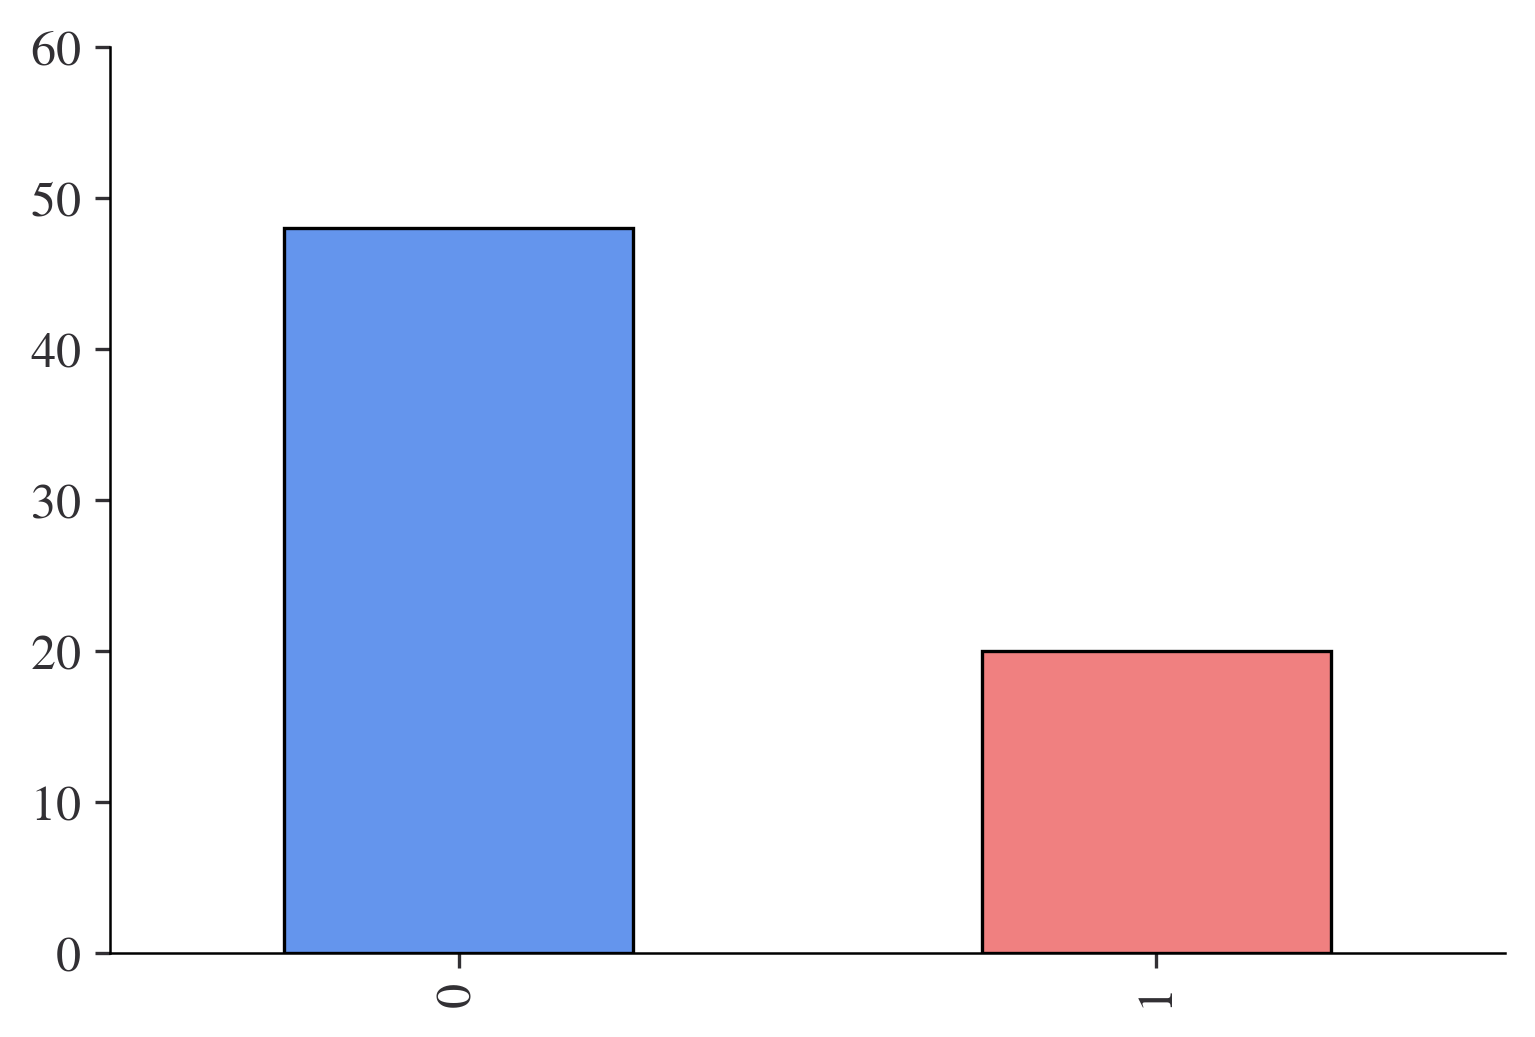

In [17]:
kinematics["label"].value_counts().plot(kind='bar', color=colors)

## Análisis exploratorio

#### Valores nulos

In [18]:
nan_values = kinematics.isna()
nan_columns = nan_values.any()
kinematics.columns[nan_columns].tolist()

[]

In [19]:
nan_values = spatiotemporal.isna()
nan_columns = nan_values.any()
spatiotemporal.columns[nan_columns].tolist()

[]

## Crear conjunto de entrenamiento y prueba

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.33, random_state=RANDOM_SEED)

for train_index, test_index in split.split(spatiotemporal, spatiotemporal["label"]):
    # Create X train and test
    st_X_train = spatiotemporal.loc[train_index]
    st_X_test = spatiotemporal.loc[test_index]
    kin_X_train = kinematics.loc[train_index]
    kin_X_test = kinematics.loc[test_index]
    stkin_X_train = spatiotemporal_kinematics.loc[train_index]
    stkin_X_test = spatiotemporal_kinematics.loc[test_index]
    
    y_train = st_X_train["label"].copy()
    y_test = st_X_test["label"].copy()
    
    # Remove label and ids from X_train and X_test
    drop_cols = ["subject", "record", "label"] 
    st_X_train.drop(columns=drop_cols, inplace=True)
    st_X_test.drop(columns=drop_cols, inplace=True)
    kin_X_train.drop(columns=drop_cols, inplace=True)
    kin_X_test.drop(columns=drop_cols, inplace=True)
    stkin_X_train.drop(columns=drop_cols, inplace=True)
    stkin_X_test.drop(columns=drop_cols, inplace=True)

In [21]:
spatiotemporal_cols = st_X_train.columns
kinematics_cols = kin_X_train.columns
spatiotemporal_kinematics_cols = stkin_X_test.columns

In [22]:
print(len(st_X_train))
print(len(y_test))

45
23


In [23]:
print(len(y_train[y_train == 1]))
print(len(y_test[y_test == 1]))

13
7


In [24]:
y_train.value_counts()

0    32
1    13
Name: label, dtype: int64

Saving figure lap3_division


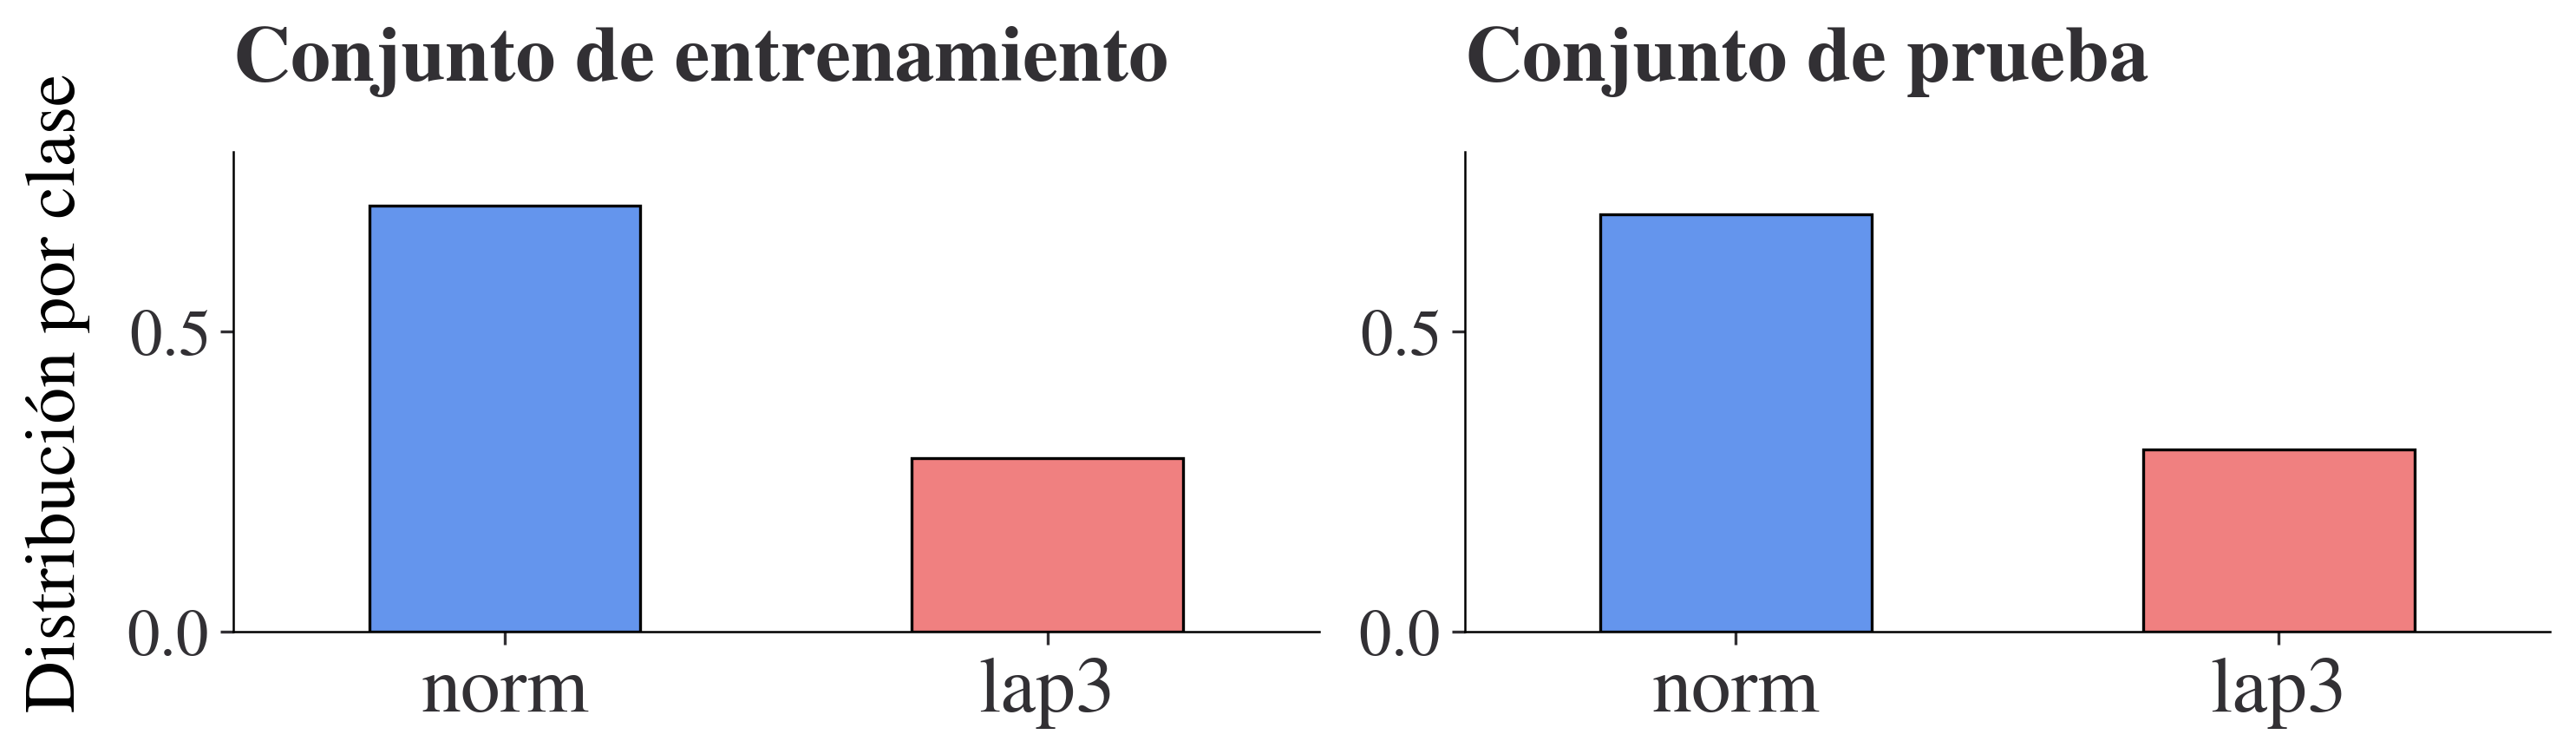

In [25]:
fig, (fig1, fig2) = plt.subplots(1, 2, figsize=(10, 3))

title_pad = 20

(y_train.value_counts()/ len(y_train)).plot(kind='bar', color=colors, ax=fig1)
fig1.set_title('Conjunto de entrenamiento', weight='bold', pad=title_pad, fontsize=22)

(y_test.value_counts() / len(y_test)).plot(kind='bar', color=colors,  ax=fig2)
fig2.set_title('Conjunto de prueba', weight='bold',  pad=title_pad, fontsize=22)

fig1.set_ylabel('Distribución por clase', fontsize=20)
#ig2.set_ylabel('Distribución por clase', fontsize=20)
fig1.tick_params(axis='both', labelsize=18)
fig2.tick_params(axis='both', labelsize=18)
fig1.tick_params(axis='x', labelrotation=0)
fig2.tick_params(axis='x', labelrotation=0)
fig1.set_xticklabels(['norm', POSITIVE_CLASS], fontsize=22)
fig2.set_xticklabels(['norm', POSITIVE_CLASS], fontsize=22)

save_fig(POSITIVE_CLASS + "_division", "./", tight_layout=True, fig_extension="pdf")

## Selección de las características más relevantes

### Parámetros espaciotemporales

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from heapq import nlargest
from operator import itemgetter

In [27]:
st_kbest = SelectKBest(score_func=f_classif, k='all')

# learn relationship from training data
st_kbest.fit(st_X_train, y_train)

# transform train input data
X_train_fs = st_kbest.transform(st_X_train)

In [28]:
st_bestfeatures = [(spatiotemporal_cols[idx], scr) for idx, scr in enumerate(st_kbest.scores_)]
st_bestfeatures = nlargest(len(st_bestfeatures), st_bestfeatures, key=itemgetter(1))


df_st = pd.DataFrame(st_bestfeatures, columns = ['variable', 'f1'])
df_st.index += 1
df_st.round(2)


,variable,f1
1,right_toe_height_norm,739.95
2,left_step_length_norm,396.87
3,left_heel_height_norm,275.16
4,right_heel_height_norm,256.38
5,cadence_norm,120.16
6,left_stride_length_norm,116.04
7,right_strike_angle,113.30
8,right_toe_off_angle,113.30
9,left_stride_duration,104.23
10,right_stride_length_norm,104.11


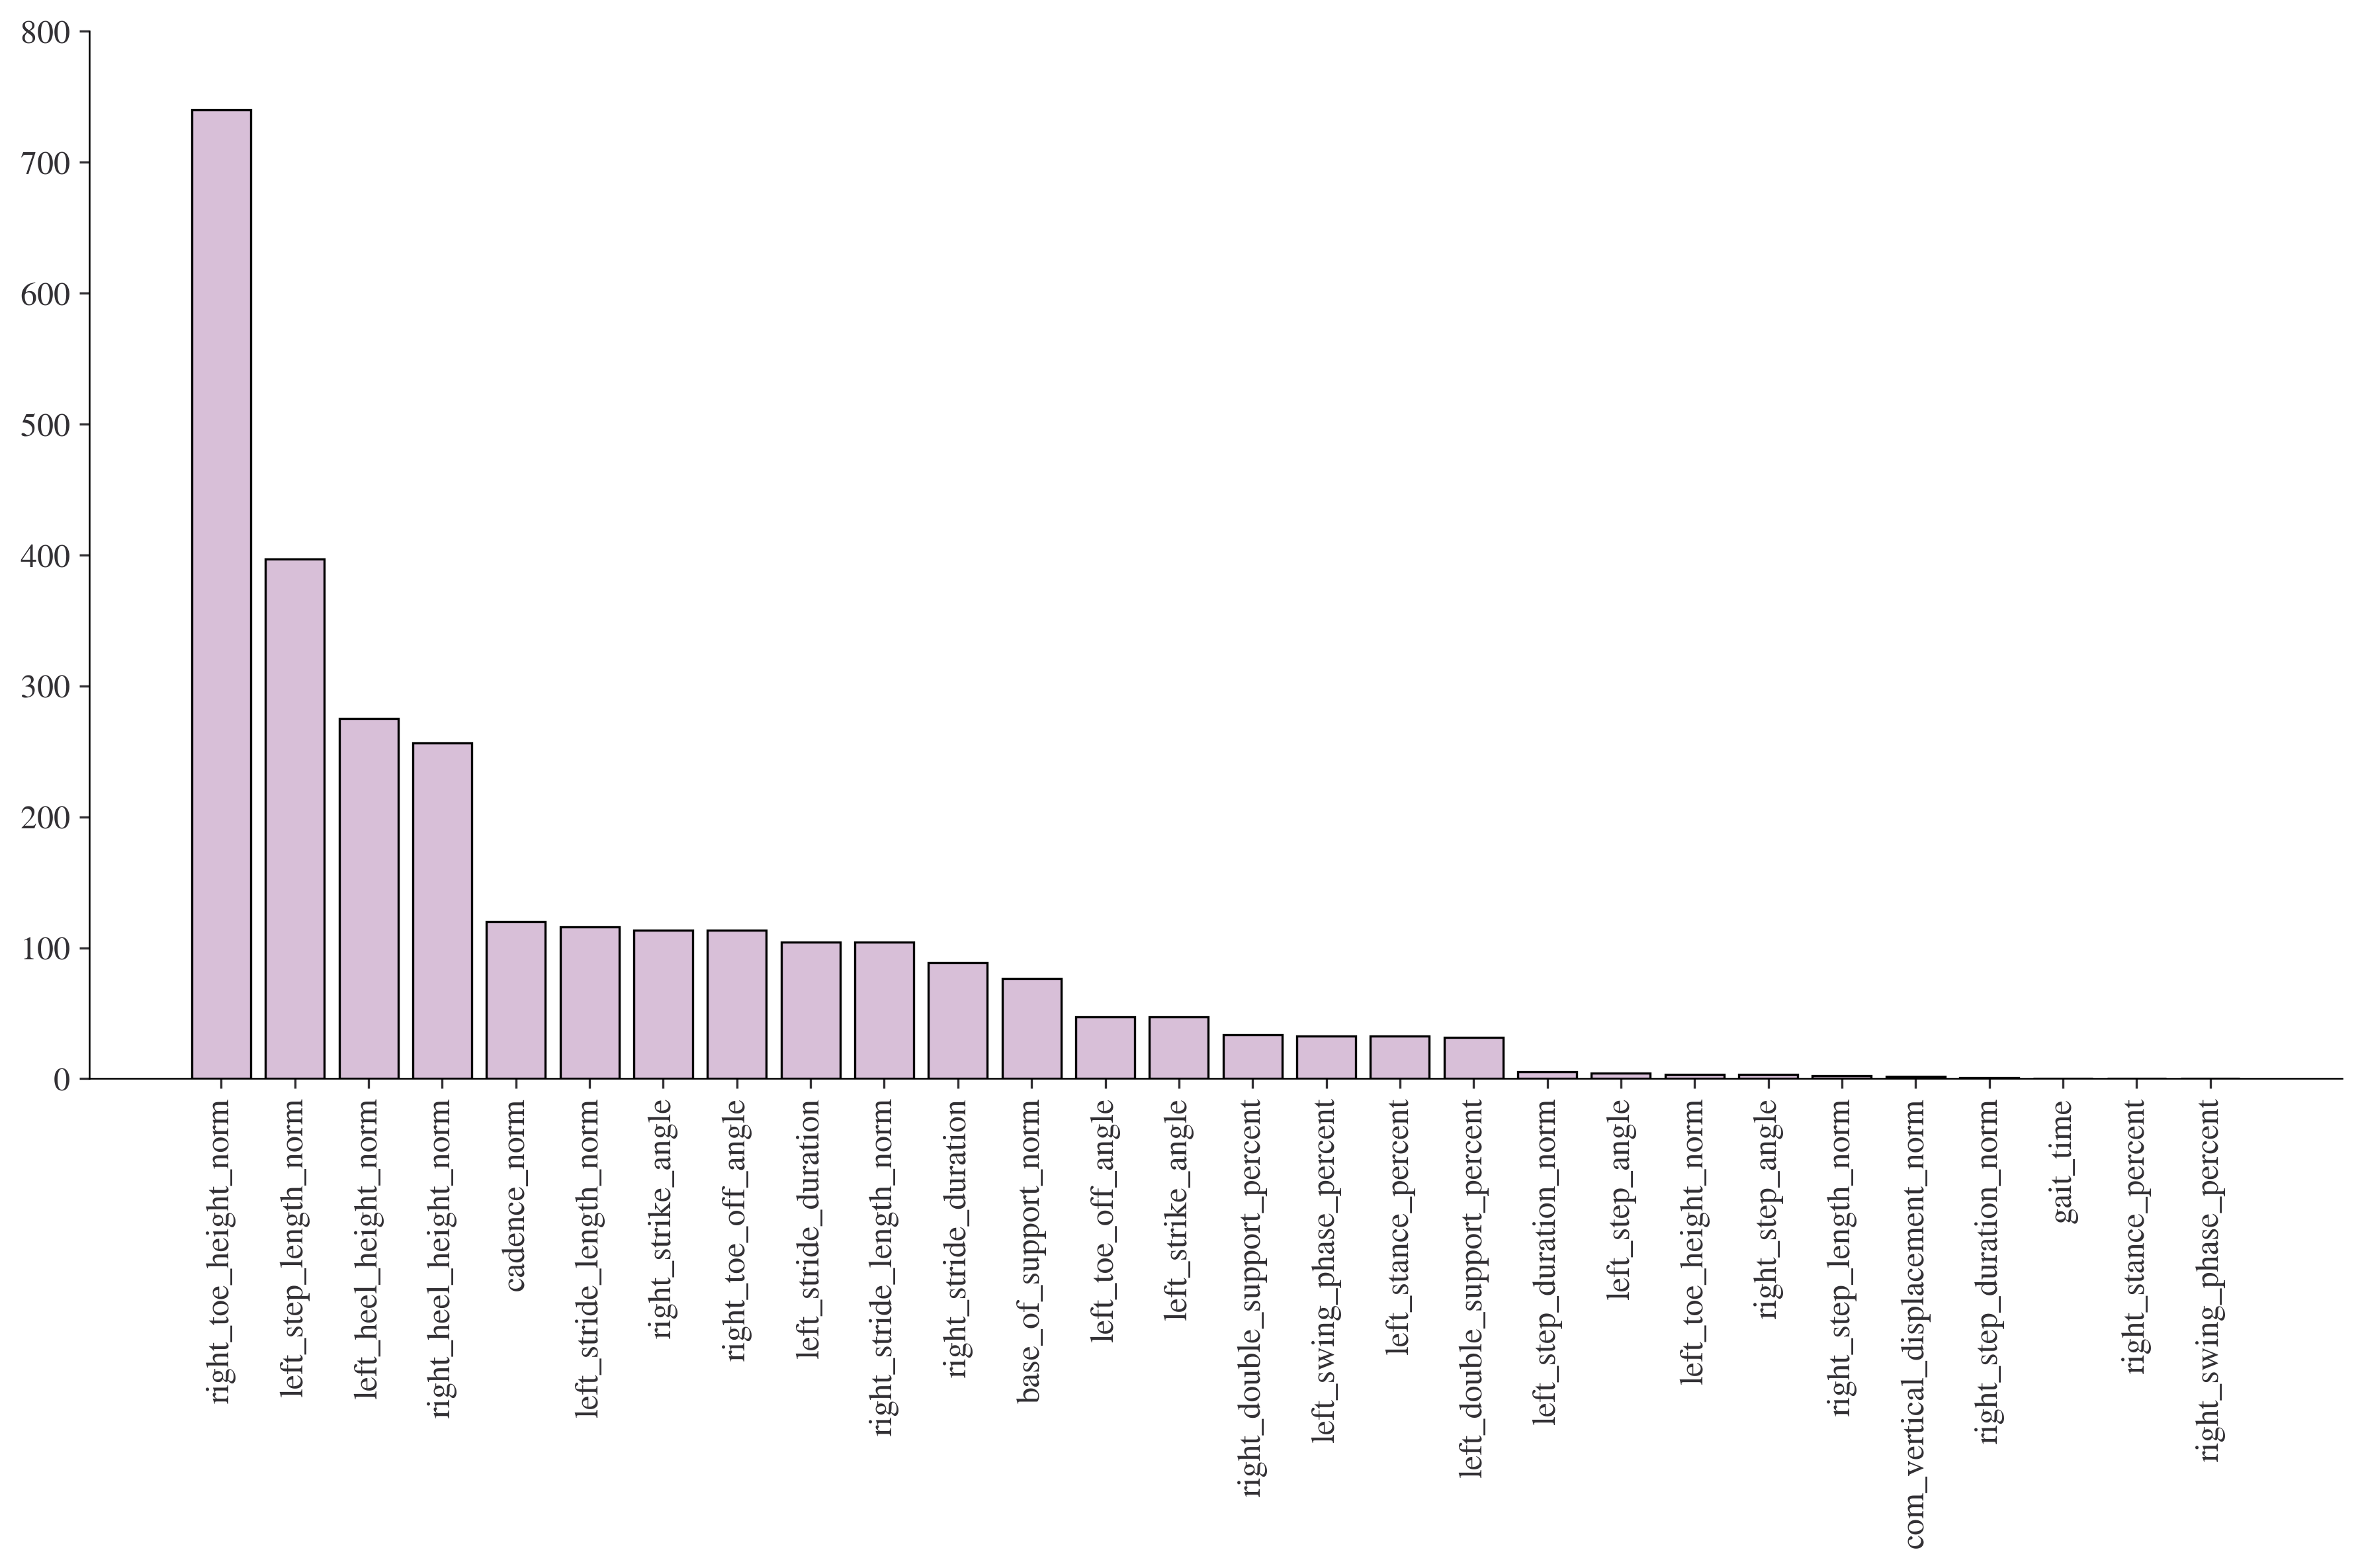

In [29]:
# plot the scores
plt.figure(figsize=(12,8))
plt.bar(*zip(*st_bestfeatures), color="thistle")

# Text rotation vertical
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Parámetros cinemáticos

In [30]:
kin_kbest = SelectKBest(score_func=f_classif, k='all')

# learn relationship from training data
kin_kbest.fit(kin_X_train, y_train)

# transform train input data
X_train_fs = kin_kbest.transform(kin_X_train)

kin_bestfeatures = [(kinematics_cols[idx], scr) for idx, scr in enumerate(kin_kbest.scores_)]

# Cogemos el mismo número de características espaciotemporales para que los gráficos sean iguales
kin_bestfeatures = nlargest(len(st_bestfeatures), kin_bestfeatures, key=itemgetter(1))

df_kin = pd.DataFrame(kin_bestfeatures, columns = ['variable', 'f1'])
df_kin.index += 1
df_kin.round(2)

,variable,f1
1,right_knee_flex_ext_Range,652.94
2,right_knee_flex_ext_Max,495.11
3,right_knee_flex_ext_Swing_Angle,155.87
4,left_knee_flex_ext_Range,139.62
5,left_knee_flex_ext_Max,94.98
6,left_pelvis_rotation_Stride_End,84.67
7,pelvis_rotation_Range,81.62
8,right_pelvis_rotation_Min,76.13
9,left_pelvis_rotation_Stride_Start,65.16
10,right_knee_val_var_Range,64.75


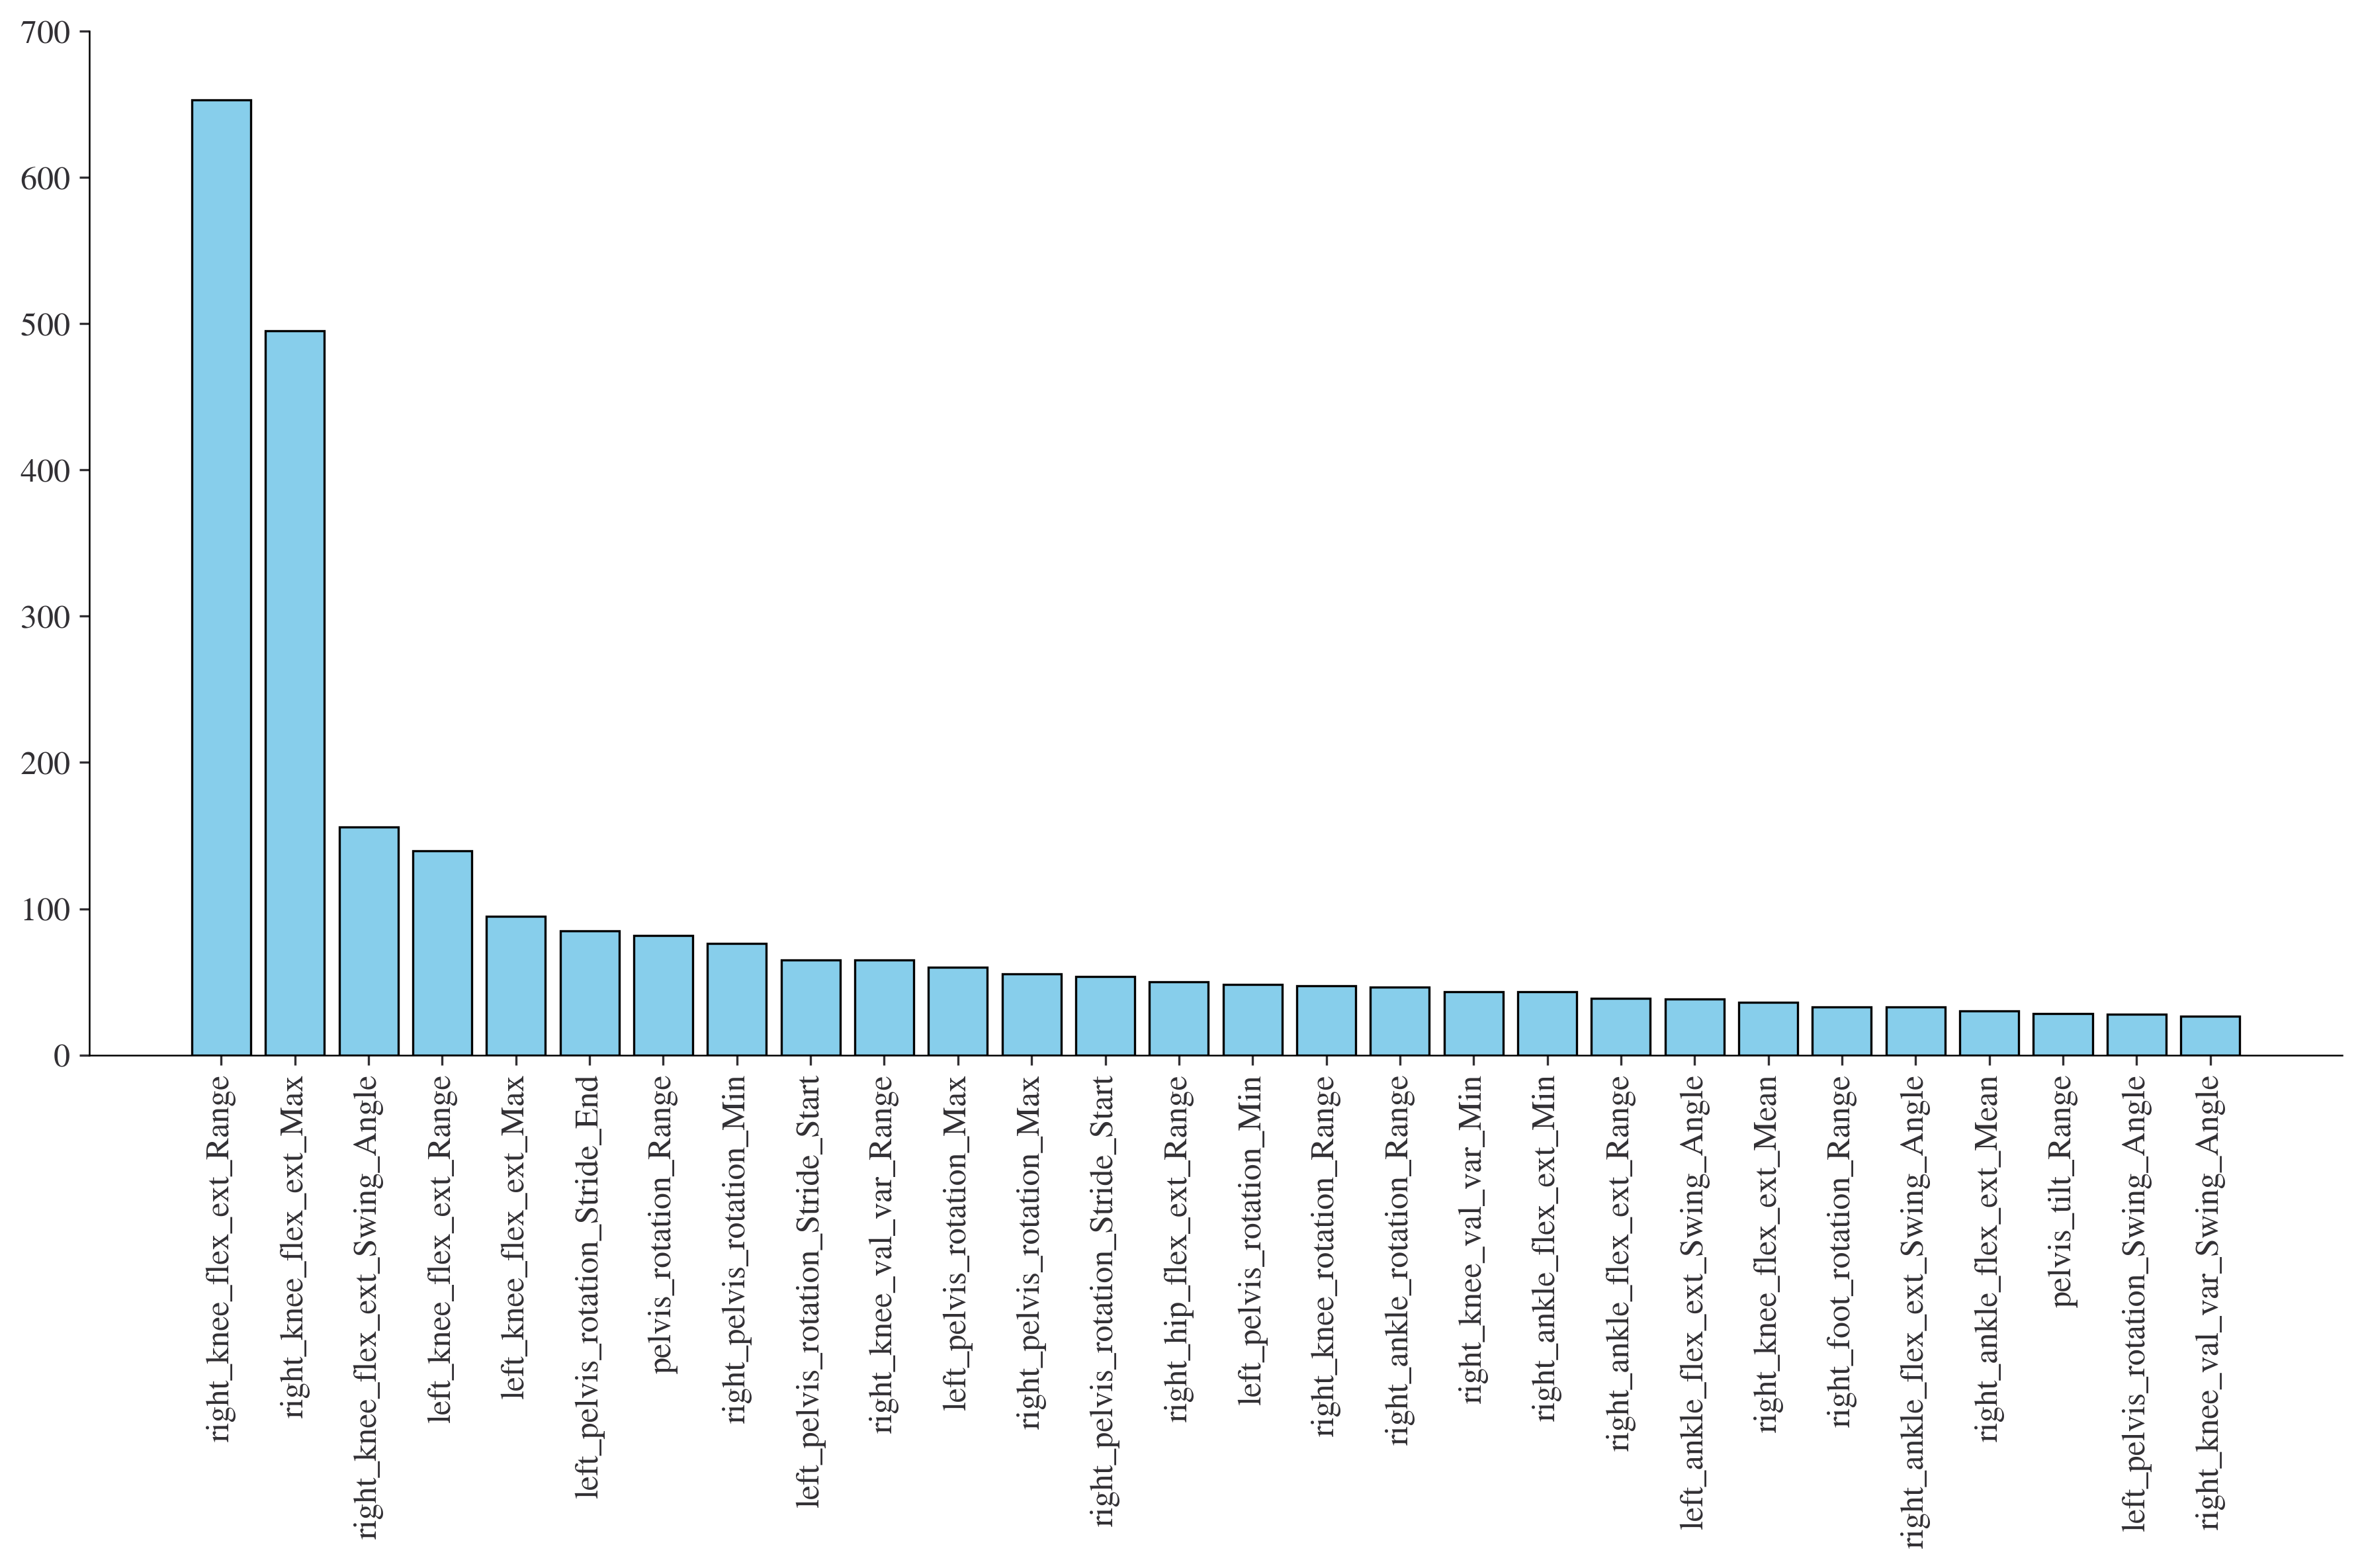

In [31]:
# plot the scores
plt.figure(figsize=(12,8))
plt.bar(*zip(*kin_bestfeatures), color="skyblue")

# Text rotation vertical
plt.xticks(rotation=90)
plt.tight_layout()

### Parámetros cinemáticos + espaciotemporales

In [32]:
stkin_kbest = SelectKBest(score_func=f_classif, k='all')

# learn relationship from training data
stkin_kbest.fit(stkin_X_train, y_train)

# transform train input data
X_train_fs = stkin_kbest.transform(stkin_X_train)

stkin_bestfeatures = [(spatiotemporal_kinematics_cols[idx], scr) for idx, scr in enumerate(stkin_kbest.scores_)]

# Cogemos el mismo número de características espaciotemporales para que los gráficos sean iguales
stkin_bestfeatures = nlargest(20, stkin_bestfeatures, key=itemgetter(1))

# what are scores for the features
df_stkin = pd.DataFrame(stkin_bestfeatures, columns = ['variable', 'f1'])
df_stkin.index += 1
df_stkin


,variable,f1
1,right_toe_height_norm,739.947059
2,right_knee_flex_ext_Range,652.944731
3,right_knee_flex_ext_Max,495.114863
4,left_step_length_norm,396.868576
5,left_heel_height_norm,275.164376
6,right_heel_height_norm,256.384129
7,right_knee_flex_ext_Swing_Angle,155.869631
8,left_knee_flex_ext_Range,139.623285
9,cadence_norm,120.162408
10,left_stride_length_norm,116.036774


Saving figure lap3_variables


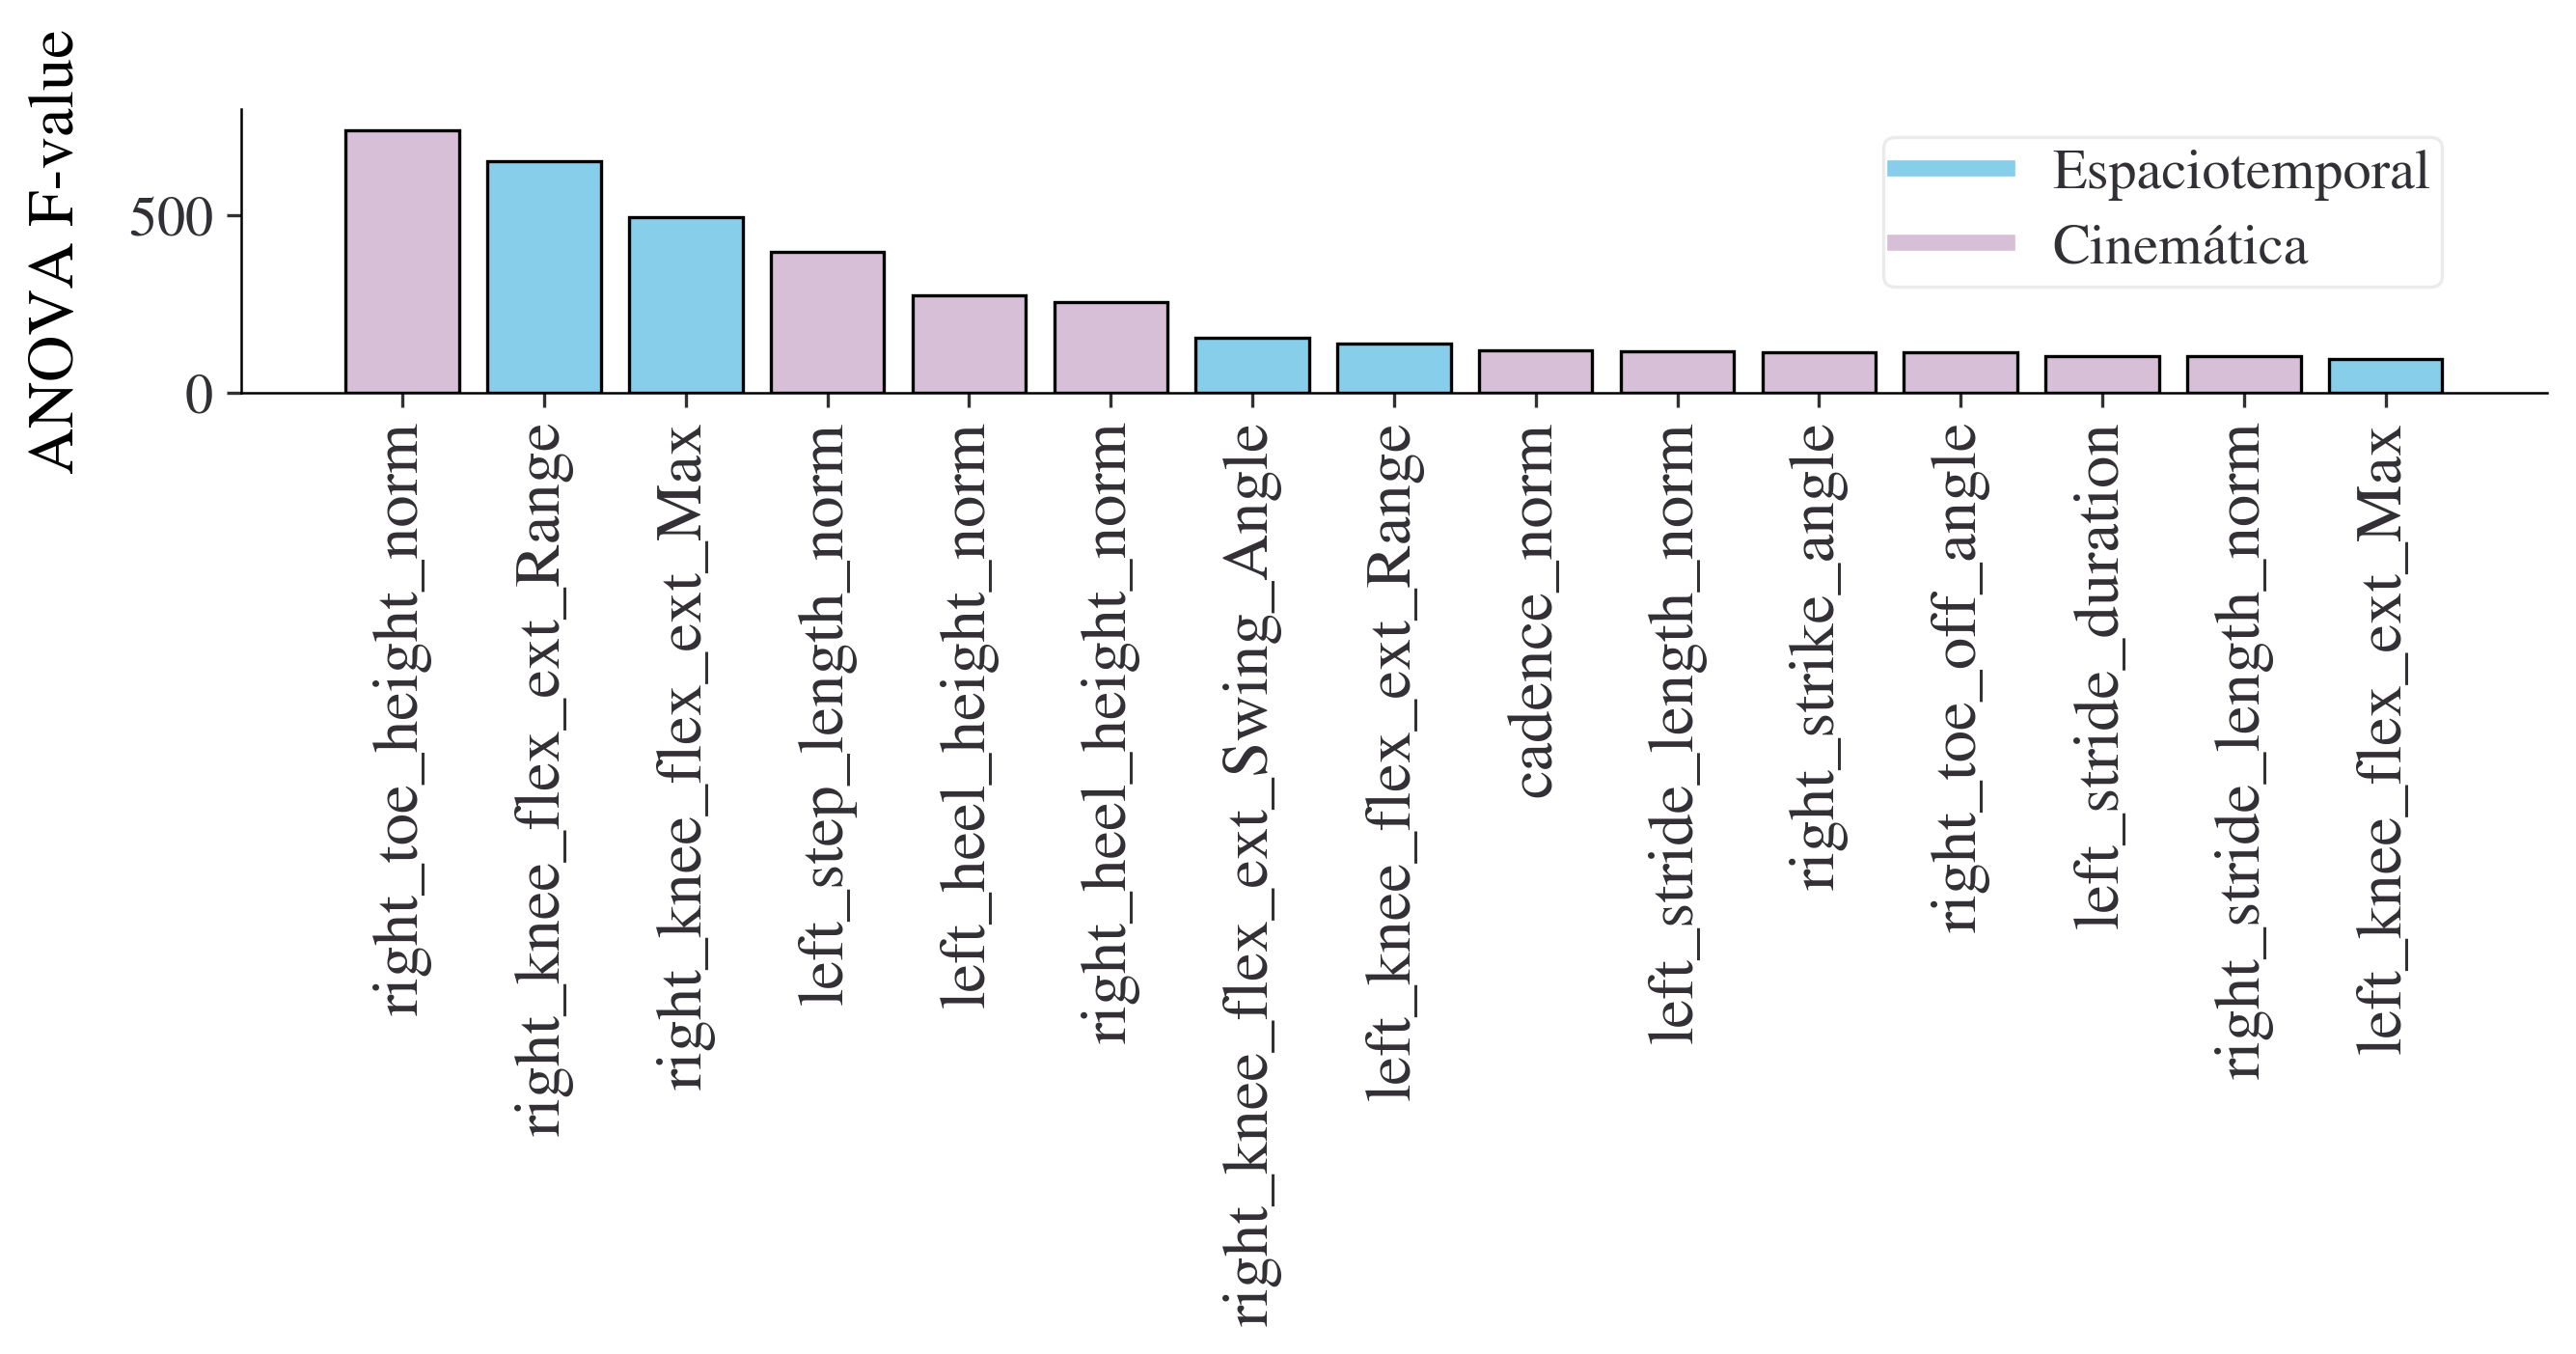

In [33]:
from matplotlib.lines import Line2D

# plot the scores
fig, ax = plt.subplots(figsize=(9,4.5))
barlist = plt.bar(*zip(*stkin_bestfeatures[:15]), color="skyblue", )
for idx, bar in enumerate(barlist):
    if stkin_bestfeatures[idx][0] in spatiotemporal_cols:
        barlist[idx].set_color('thistle')
        barlist[idx].set_edgecolor('black')

# Text rotation vertical
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()

custom_lines = [Line2D([0], [0], color="skyblue", lw=4),
                Line2D([0], [0], color= "thistle", lw=4)]

plt.ylabel('ANOVA F-value', fontsize=16)



ax.legend(custom_lines, ['Espaciotemporal', 'Cinemática',], loc='upper left', bbox_to_anchor=(0.7, 1), prop={'size': 14})
save_fig(POSITIVE_CLASS + "_variables", "./", tight_layout=True, fig_extension="pdf")

# Entrenamiento

#### *Pipeline* de preparación

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [35]:
n_features_list = [5, 10, 15,]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV

def get_pipeline(features, model, scaler=True):
    pipeline = [ ('selector', ColumnsSelector(columns=features))]
    if scaler:
        pipeline.append(('scaler', QuantileTransformer(output_distribution='uniform', n_quantiles=40)),)
    if model:
        pipeline.append(('model', model))
    return Pipeline(steps=pipeline)

#### KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn(X_train, y_train, X_test, y_test, features, cv=10):
    #---creating odd list of K for KNN---
    max_k = len(X_train)
    k_candidates = list(range(3,int(max_k * ((cv - 1)/cv)), 2))

    knn_param_grid = {
        'model__n_neighbors': k_candidates,
        'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
    }
    
    knn_model = get_pipeline(features, KNeighborsClassifier())
    knn_gs = GridSearchCV(knn_model, knn_param_grid, cv=cv, verbose = 1, scoring='accuracy', n_jobs=-1)
    knn_gs_results = knn_gs.fit(X_train,  y_train)
    
     
    # Get best model
    best_knn_model = knn_gs_results.best_estimator_
    train_info = {'algorithm': 'KNN', 'n_features': len(features)}

    train_info["mean_fit_time"] = round(knn_gs_results.cv_results_['mean_fit_time'][knn_gs_results.best_index_] * 1000, 3) # milliseconds
    train_info["std_fit_time"] = round(knn_gs_results.cv_results_['std_fit_time'][knn_gs_results.best_index_] * 1000, 3) # milliseconds
    train_info["mean_train_score"] = 100 * knn_gs_results.cv_results_['mean_test_score'][knn_gs_results.best_index_]
    train_info["std_train_score"] = 100 * knn_gs_results.cv_results_['std_test_score'][knn_gs_results.best_index_]

    # Evaluate model
    final_predictions = best_knn_model.predict(X_test)


    eval_metrics = {'algorithm': 'KNN', 'n_features': len(features)}
    eval_metrics['accuracy'] = 100 * accuracy_score(y_test, final_predictions)
    eval_metrics['balanced_accuracy'] = 100 * balanced_accuracy_score(y_test, final_predictions)
    eval_metrics['precision'] = 100 * precision_score(y_test, final_predictions)
    eval_metrics['recall'] = 100 * recall_score(y_test, final_predictions)
    eval_metrics['f1'] = 100 * f1_score(y_test, final_predictions)
    eval_metrics['roc_auc'] = 100 * roc_auc_score(y_test, final_predictions)
    
    return best_knn_model, train_info, eval_metrics

#### Complement NB

In [38]:
from sklearn.naive_bayes import ComplementNB

def train_complementNB(X_train, y_train, X_test, y_test, features, cv=10):
    
    # Train DecisionTree model
    bayes_model =  get_pipeline(features, ComplementNB())
    bayes_model.fit(X_train, y_train)
    scores = cross_validate(bayes_model, X_train,  y_train, cv=10, scoring='accuracy', return_train_score=True)
    
    train_info = {'algorithm': 'CNB', 'n_features': len(features)}
    train_info['mean_fit_time'] = round(scores['fit_time'].mean() * 1000, 3)
    train_info['std_fit_time'] = round(scores['fit_time'].std() * 1000, 3)
    train_info["mean_train_score"] = 100 * scores['test_score'].mean()
    train_info["std_train_score"] = 100 * scores['test_score'].std()
    
    # Evaluate DecisionTree model
    final_predictions = bayes_model.predict(X_test)
    
    eval_metrics = {'algorithm': 'CNB', 'n_features': len(features)}
    eval_metrics['accuracy'] = 100 * accuracy_score(y_test, final_predictions)
    eval_metrics['balanced_accuracy'] = 100 * balanced_accuracy_score(y_test, final_predictions)
    eval_metrics['precision'] = 100 * precision_score(y_test, final_predictions)
    eval_metrics['recall'] = 100 * recall_score(y_test, final_predictions)
    eval_metrics['f1'] = 100 * f1_score(y_test, final_predictions)
    eval_metrics['roc_auc'] = 100 * roc_auc_score(y_test, final_predictions)
    
    return bayes_model, train_info, eval_metrics

#### Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train, X_test, y_test, features, cv=10):
    tree_param_grid = {
        'model__max_leaf_nodes': list(range(2, 50 + 1)),
        'model__min_samples_split': list(range(2, 6 + 1)),
        'model__max_depth': list(range(1, 20 + 1))
    }
    
    dt_model = get_pipeline(features, DecisionTreeClassifier(criterion="gini", random_state=RANDOM_SEED), scaler=False)
    dt_gs = GridSearchCV(dt_model, tree_param_grid, cv=cv, verbose = 1, scoring='accuracy', n_jobs=-1)
    dt_gs_results = dt_gs.fit(X_train,  y_train)
    
    
    # Get best model
    best_dt_model = dt_gs_results.best_estimator_
    train_info = {'algorithm': 'DT', 'n_features': len(features)}

    train_info["mean_fit_time"] = round(dt_gs_results.cv_results_['mean_fit_time'][dt_gs_results.best_index_] * 1000, 3) # milliseconds
    train_info["std_fit_time"] = round(dt_gs_results.cv_results_['std_fit_time'][dt_gs_results.best_index_] * 1000, 3) # milliseconds
    train_info["mean_train_score"] = 100 * dt_gs_results.cv_results_['mean_test_score'][dt_gs_results.best_index_]
    train_info["std_train_score"] = 100 * dt_gs_results.cv_results_['std_test_score'][dt_gs_results.best_index_]

    # Evaluate model
    final_predictions = best_dt_model.predict(X_test)


    eval_metrics = {'algorithm': 'DT', 'n_features': len(features)}
    eval_metrics['accuracy'] = 100 * accuracy_score(y_test, final_predictions)
    eval_metrics['balanced_accuracy'] = 100 * balanced_accuracy_score(y_test, final_predictions)
    eval_metrics['precision'] = 100 * precision_score(y_test, final_predictions)
    eval_metrics['recall'] = 100 * recall_score(y_test, final_predictions)
    eval_metrics['f1'] = 100 * f1_score(y_test, final_predictions)
    eval_metrics['roc_auc'] = 100 * roc_auc_score(y_test, final_predictions)
    
    return best_dt_model, train_info, eval_metrics

#### SVC

In [40]:
from sklearn.svm import SVC

def train_svc(X_train, y_train, X_test, y_test, features, cv=10):
    # Create SVC model
    svc_model = get_pipeline(features, SVC(random_state=RANDOM_SEED, kernel = 'rbf', probability=True))

    # First search
    c_params = np.logspace(-5, 15, 11, base=2)
    gamma_params = np.logspace(-15, 3, 10, base=2)
    svc_grid_1 = {
        'model__C': c_params,
        'model__gamma': gamma_params,
    }
    svc_search1 = GridSearchCV(svc_model, svc_grid_1, cv=cv, verbose = 1, scoring='accuracy', n_jobs=-1)
    svc_search1_results = svc_search1.fit(X_train,  y_train)
    
    # Second search
    c_exp = math.log(svc_search1_results.best_params_['model__C'],2)
    gamma_exp = math.log(svc_search1_results.best_params_['model__gamma'],2)

    c_params_2 = np.logspace(c_exp - 2, c_exp + 2, 17, base=2)
    gamma_params_2 = np.logspace(gamma_exp - 2, gamma_exp + 2, 17, base=2)

    svc_grid_2 = {
        'model__C': c_params_2,
        'model__gamma': gamma_params_2,
    }
    
    svc_search2 = GridSearchCV(svc_model, svc_grid_2, cv=cv, verbose = 1, scoring='accuracy', n_jobs=-1)
    svc_search2_results = svc_search2.fit(X_train,  y_train)

    # Get best model
    svc_best_model = svc_search2_results.best_estimator_
    train_info = {'algorithm': 'SVC', 'n_features': len(features)}

    train_info["mean_fit_time"] = round(svc_search2.cv_results_['mean_fit_time'][svc_search2.best_index_] * 1000, 3) # milliseconds
    train_info["std_fit_time"] = round(svc_search2.cv_results_['std_fit_time'][svc_search2.best_index_] * 1000, 3) # milliseconds
    train_info["mean_train_score"] = 100 * svc_search2.cv_results_['mean_test_score'][svc_search2.best_index_]
    train_info["std_train_score"] = 100 * svc_search2.cv_results_['std_test_score'][svc_search2.best_index_]

    # Evaluate model
    final_predictions = svc_best_model.predict(X_test)


    eval_metrics = {'algorithm': 'SVC', 'n_features': len(features)}
    eval_metrics['accuracy'] = 100 * accuracy_score(y_test, final_predictions)
    eval_metrics['balanced_accuracy'] = 100 * balanced_accuracy_score(y_test, final_predictions)
    eval_metrics['precision'] = 100 * precision_score(y_test, final_predictions)
    eval_metrics['recall'] = 100 * recall_score(y_test, final_predictions)
    eval_metrics['f1'] = 100 * f1_score(y_test, final_predictions)
    eval_metrics['roc_auc'] = 100 * roc_auc_score(y_test, final_predictions)
    
    return svc_best_model, train_info, eval_metrics


#### MLP

In [41]:
import kerastuner as kt

class MLPModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        keras.backend.clear_session()
        np.random.seed(RANDOM_SEED)
        tf.random.set_seed(RANDOM_SEED)

        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=self.input_shape))

        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                      min_value=5,
                                                      max_value=40,
                                                      step=5),
                                         activation='relu'))

        # Output layer
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values = [5e-1, 7e-1, 1e-1, 1e-2, 5e-2, 7e-2, 1e-3, 5e-3, 1e-4]) 

        model.compile(optimizer = keras.optimizers.Adam(lr = hp_learning_rate), 
                      loss='binary_crossentropy', metrics = ['accuracy'])

        return model

In [42]:
# https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [43]:
def train_mlp(X_train, y_train, X_test, y_test, features, epochs=10):
    # Prepare data
    pipeline = get_pipeline(features, None)
    X_train_tr = pipeline.fit_transform(X_train)
    


    tuner_directory = 'keras-tuner'
    if os.path.exists(tuner_directory):
        shutil.rmtree(tuner_directory)

    hyper = MLPModel(len(features))
    tuner = kt.Hyperband(hyper,
                         objective = 'accuracy', 
                         max_epochs = epochs,
                         factor = 3,
                         seed = 42,
                         directory = tuner_directory,
                         project_name = str(n_features) + '_tuner_1')
    
    tuner.search(X_train_tr, y_train, epochs = 50, verbose=0)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    # Weights not trained here, as opposed to `tuner.get_best_models()` which includes weights
    best_model = tuner.hypermodel.build(best_hps)
    time_callback = TimeHistory()
    history = best_model.fit(X_train_tr, y_train, epochs=10, verbose=0, callbacks=[time_callback])
    
    train_info = {'algorithm': 'MLP', 'n_features': len(features)}
    train_info["mean_fit_time"] = round(np.array(time_callback.times).mean() * 1000, 3)  # milliseconds
    train_info["std_fit_time"] = round(np.array(time_callback.times).std() * 1000, 3) # milliseconds
    train_info["mean_train_score"] = 100 * np.array(history.history['accuracy']).mean()
    train_info["std_train_score"] = 100 * np.array(history.history['accuracy']).std()
    
    # Evaluate model
    X_test_tr = pipeline.transform(X_test)
    final_predictions = best_model.predict(X_test_tr).astype(int)
    final_predictions = list(itertools.chain(*final_predictions))
    
    
    eval_metrics = {'algorithm': 'MLP', 'n_features': len(features)}
    eval_metrics['accuracy'] = 100 * accuracy_score(y_test, final_predictions)
    eval_metrics['balanced_accuracy'] = 100 * balanced_accuracy_score(y_test, final_predictions)
    eval_metrics['precision'] = 100 * precision_score(y_test, final_predictions)
    eval_metrics['recall'] = 100 * recall_score(y_test, final_predictions)
    eval_metrics['f1'] = 100 * f1_score(y_test, final_predictions)
    eval_metrics['roc_auc'] = 100 * roc_auc_score(y_test, final_predictions)
    
    return best_model, train_info, eval_metrics

## Parámetros espaciotemporales

In [44]:
models = {
    "st": {
        "CNB": [],
        "KNN": [],
        "DT": [],
        "SVC": [],
        "MLP": []
    },
    "kin": {
        "CNB": [],
        "KNN": [],
        "DT": [],
        "SVC": [],
        "MLP": []
    },
    "stkin": {
        "CNB": [],
        "KNN": [],
        "DT": [],
        "SVC": [],
        "MLP": []
    },
}

In [45]:
st_train_results = []
st_metrics_results = []

# Entrenamiento sólo con parámetros espaciotemporales
for n_features in n_features_list:
    print("n_features: " + str(n_features))
    st_features = [var[0] for var in st_bestfeatures[:n_features]]
    print(st_features)
    print("\n")
    
    # -------------
    # CNB
    # -------------
    print("Training Complement Naive Bayes with " + str(n_features) + " features")
    
    # Train model
    st_cnb_model, st_cnb_train, st_cnb_metrics = train_complementNB(st_X_train, y_train, st_X_test, y_test, st_features)
    
    # Save results
    st_train_results.append(st_cnb_train)  
    st_metrics_results.append(st_cnb_metrics)
    models["st"]["CNB"].append((n_features, st_cnb_model))
    
    # -------------
    # KNN
    # -------------
    print("Training KNN with " + str(n_features) + " features")
    
    # Train model
    st_knn_model, st_knn_train, st_knn_metrics = train_knn(st_X_train, y_train, st_X_test, y_test, st_features)
    
    # Save results
    st_train_results.append(st_knn_train)  
    st_metrics_results.append(st_knn_metrics)  
    models["st"]["KNN"].append((n_features, st_knn_model))
    
    
    # -------------
    # Decision Tree
    # -------------
    print("Training Decision Tree with " + str(n_features) + " features")
    
    # Train model
    st_dt_model, st_dt_train, st_dt_metrics = train_decision_tree(st_X_train, y_train, st_X_test, y_test, st_features)
    
    # Save results
    st_train_results.append(st_dt_train)  
    st_metrics_results.append(st_dt_metrics)
    models["st"]["DT"].append((n_features, st_dt_model))
    
    
    # -------------
    # SVC (SVM)
    # -------------
    print("Training SVC with " + str(n_features) + " features")
    
    # Train model
    st_svc_model, st_svc_train, st_svc_metrics = train_svc(st_X_train, y_train, st_X_test, y_test, st_features)
    
    # Save results    
    st_train_results.append(st_svc_train)  
    st_metrics_results.append(st_svc_metrics)  
    models["st"]["SVC"].append((n_features, st_svc_model))
    

    # -------------
    # MLP (Red neuronal)
    # -------------
    print("Training MLP with " + str(n_features) + " features")
    
    # Train model
    st_mlp_model, st_mlp_train, st_mlp_metrics = train_mlp(st_X_train, y_train, st_X_test, y_test, st_features)
    
    # Save results    
    st_train_results.append(st_mlp_train)  
    st_metrics_results.append(st_mlp_metrics) 
    models["st"]["MLP"].append((n_features, st_mlp_model))

    
    
    # Save model
    print("-" * 30)

n_features: 5
['right_toe_height_norm', 'left_step_length_norm', 'left_heel_height_norm', 'right_heel_height_norm', 'cadence_norm']


Training Complement Naive Bayes with 5 features
Training KNN with 5 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 5 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 4468 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 12468 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 38068 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   47.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 5 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    4.2s finished


Training MLP with 5 features
INFO:tensorflow:Oracle triggered exit


C:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


------------------------------
n_features: 10
['right_toe_height_norm', 'left_step_length_norm', 'left_heel_height_norm', 'right_heel_height_norm', 'cadence_norm', 'left_stride_length_norm', 'right_strike_angle', 'right_toe_off_angle', 'left_stride_duration', 'right_stride_length_norm']


Training Complement Naive Bayes with 10 features
Training KNN with 10 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 10 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 4468 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 12468 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 38068 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   52.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 10 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    5.0s finished


Training MLP with 10 features
INFO:tensorflow:Oracle triggered exit
------------------------------
n_features: 15
['right_toe_height_norm', 'left_step_length_norm', 'left_heel_height_norm', 'right_heel_height_norm', 'cadence_norm', 'left_stride_length_norm', 'right_strike_angle', 'right_toe_off_angle', 'left_stride_duration', 'right_stride_length_norm', 'right_stride_duration', 'base_of_support_norm', 'left_toe_off_angle', 'left_strike_angle', 'right_double_support_percent']


Training Complement Naive Bayes with 15 features
Training KNN with 15 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 15 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 8180 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 24180 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 46580 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   53.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 15 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    5.6s finished


Training MLP with 15 features
INFO:tensorflow:Oracle triggered exit
------------------------------


In [46]:
st_train_info_df = pd.DataFrame(st_train_results).round(1)
st_train_info_df['fit_time'] = st_train_info_df.apply(lambda row: str(row.mean_fit_time) + " + " + str(row.std_fit_time) , axis=1)
st_train_info_df['train_score'] = st_train_info_df.apply(lambda row: str(row.mean_train_score) + " + " + str(row.std_train_score) , axis=1)
st_train_info_df = st_train_info_df[['algorithm', 'n_features', 'train_score', 'fit_time']]
st_train_info_df

,algorithm,n_features,train_score,fit_time
0,CNB,5,39.5 + 23.0,5.3 + 0.8
1,KNN,5,100.0 + 0.0,5.9 + 2.0
2,DT,5,100.0 + 0.0,3.0 + 0.6
3,SVC,5,100.0 + 0.0,4.9 + 0.4
4,MLP,5,93.3 + 10.1,34.5 + 100.6
5,CNB,10,100.0 + 0.0,4.9 + 0.3
6,KNN,10,100.0 + 0.0,6.2 + 1.2
7,DT,10,97.5 + 7.5,2.7 + 0.5
8,SVC,10,100.0 + 0.0,5.9 + 0.8
9,MLP,10,90.0 + 19.0,40.2 + 117.5


In [47]:
st_metrics_df = pd.DataFrame(st_metrics_results).round(2)[['algorithm', 'n_features', 'accuracy', 'f1', 'roc_auc' ]]
st_metrics_df

,algorithm,n_features,accuracy,f1,roc_auc
0,CNB,5,60.87,52.63,63.84
1,KNN,5,100.00,100.00,100.00
2,DT,5,100.00,100.00,100.00
3,SVC,5,100.00,100.00,100.00
4,MLP,5,69.57,0.00,50.00
5,CNB,10,100.00,100.00,100.00
6,KNN,10,100.00,100.00,100.00
7,DT,10,100.00,100.00,100.00
8,SVC,10,100.00,100.00,100.00
9,MLP,10,100.00,100.00,100.00


## Parámetros cinemáticos

In [48]:
kin_train_results = []
kin_metrics_results = []

# Entrenamiento sólo con parámetros espaciotemporales
for n_features in n_features_list:
    print("n_features: " + str(n_features))
    kin_features = [var[0] for var in kin_bestfeatures[:n_features]]
    print(kin_features)
    print("\n")
    
    # -------------
    # CNB
    # -------------
    print("Training Complement Naive Bayes with " + str(n_features) + " features")
    
    # Train model
    kin_cnb_model, kin_cnb_train, kin_cnb_metrics = train_complementNB(kin_X_train, y_train, kin_X_test, y_test, kin_features)
    
    # Save results
    kin_train_results.append(kin_cnb_train)  
    kin_metrics_results.append(kin_cnb_metrics)
    models["kin"]["CNB"].append((n_features, kin_cnb_model))
    
    # -------------
    # KNN
    # -------------
    print("Training KNN with " + str(n_features) + " features")
    
    # Train model
    kin_knn_model, kin_knn_train, kin_knn_metrics = train_knn(kin_X_train, y_train, kin_X_test, y_test, kin_features)
    
    # Save results
    kin_train_results.append(kin_knn_train)  
    kin_metrics_results.append(kin_knn_metrics)  
    models["kin"]["KNN"].append((n_features, kin_knn_model))
    
    
    # -------------
    # Decision Tree
    # -------------
    print("Training Decision Tree with " + str(n_features) + " features")
    
    # Train model
    kin_dt_model, kin_dt_train, kin_dt_metrics = train_decision_tree(kin_X_train, y_train, kin_X_test, y_test, kin_features)
    
    # Save results
    kin_train_results.append(kin_dt_train)  
    kin_metrics_results.append(kin_dt_metrics)
    models["kin"]["DT"].append((n_features, kin_dt_model))
    
    
    # -------------
    # SVC (SVM)
    # -------------
    print("Training SVC with " + str(n_features) + " features")
    
    # Train model
    kin_svc_model, kin_svc_train, kin_svc_metrics = train_svc(kin_X_train, y_train, kin_X_test, y_test, kin_features)
    
    # Save results    
    kin_train_results.append(kin_svc_train)  
    kin_metrics_results.append(kin_svc_metrics)
    models["kin"]["SVC"].append((n_features, kin_svc_model))
    

    # -------------
    # MLP (Red neuronal)
    # -------------
    print("Training MLP with " + str(n_features) + " features")
    
    # Train model
    kin_mlp_model, kin_mlp_train, kin_mlp_metrics = train_mlp(kin_X_train, y_train, kin_X_test, y_test, kin_features)
    
    # Save results    
    kin_train_results.append(kin_mlp_train)  
    kin_metrics_results.append(kin_mlp_metrics)
    models["kin"]["MLP"].append((n_features, kin_mlp_model))

    
    
    # Save model
    print("-" * 30)

n_features: 5
['right_knee_flex_ext_Range', 'right_knee_flex_ext_Max', 'right_knee_flex_ext_Swing_Angle', 'left_knee_flex_ext_Range', 'left_knee_flex_ext_Max']


Training Complement Naive Bayes with 5 features
Training KNN with 5 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 5 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 4468 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 12468 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 38068 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   56.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 5 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2879 out of 2890 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    5.9s finished


Training MLP with 5 features
INFO:tensorflow:Oracle triggered exit
------------------------------
n_features: 10
['right_knee_flex_ext_Range', 'right_knee_flex_ext_Max', 'right_knee_flex_ext_Swing_Angle', 'left_knee_flex_ext_Range', 'left_knee_flex_ext_Max', 'left_pelvis_rotation_Stride_End', 'pelvis_rotation_Range', 'right_pelvis_rotation_Min', 'left_pelvis_rotation_Stride_Start', 'right_knee_val_var_Range']


Training Complement Naive Bayes with 10 features
Training KNN with 10 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 10 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2148 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 8756 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 19956 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 34356 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:  1.0min finished


Training SVC with 10 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    5.1s finished


Training MLP with 10 features
INFO:tensorflow:Oracle triggered exit
------------------------------
n_features: 15
['right_knee_flex_ext_Range', 'right_knee_flex_ext_Max', 'right_knee_flex_ext_Swing_Angle', 'left_knee_flex_ext_Range', 'left_knee_flex_ext_Max', 'left_pelvis_rotation_Stride_End', 'pelvis_rotation_Range', 'right_pelvis_rotation_Min', 'left_pelvis_rotation_Stride_Start', 'right_knee_val_var_Range', 'left_pelvis_rotation_Max', 'right_pelvis_rotation_Max', 'right_pelvis_rotation_Stride_Start', 'right_hip_flex_ext_Range', 'left_pelvis_rotation_Min']


Training Complement Naive Bayes with 15 features
Training KNN with 15 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 15 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 4468 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 12468 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 38068 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 15 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    7.4s finished


Training MLP with 15 features
INFO:tensorflow:Oracle triggered exit
------------------------------


In [49]:
kin_train_info_df = pd.DataFrame(kin_train_results).round(1)
kin_train_info_df['fit_time'] = kin_train_info_df.apply(lambda row: str(row.mean_fit_time) + " + " + str(row.std_fit_time) , axis=1)
kin_train_info_df['train_score'] = kin_train_info_df.apply(lambda row: str(row.mean_train_score) + " + " + str(row.std_train_score) , axis=1)
kin_train_info_df = kin_train_info_df[['algorithm', 'n_features', 'train_score', 'fit_time']]
kin_train_info_df

,algorithm,n_features,train_score,fit_time
0,CNB,5,57.5 + 16.2,4.6 + 0.5
1,KNN,5,100.0 + 0.0,4.9 + 0.8
2,DT,5,100.0 + 0.0,2.6 + 0.6
3,SVC,5,100.0 + 0.0,6.4 + 2.6
4,MLP,5,92.7 + 10.1,42.0 + 121.9
5,CNB,10,100.0 + 0.0,5.1 + 0.3
6,KNN,10,100.0 + 0.0,5.9 + 1.5
7,DT,10,100.0 + 0.0,2.9 + 0.5
8,SVC,10,100.0 + 0.0,6.2 + 0.6
9,MLP,10,97.1 + 8.7,36.1 + 105.4


In [50]:
kin_metrics_df = pd.DataFrame(kin_metrics_results).round(2)[['algorithm', 'n_features', 'accuracy', 'f1', 'roc_auc' ]]
kin_metrics_df

,algorithm,n_features,accuracy,f1,roc_auc
0,CNB,5,65.22,50.00,62.95
1,KNN,5,100.00,100.00,100.00
2,DT,5,100.00,100.00,100.00
3,SVC,5,100.00,100.00,100.00
4,MLP,5,100.00,100.00,100.00
5,CNB,10,100.00,100.00,100.00
6,KNN,10,95.65,93.33,96.88
7,DT,10,100.00,100.00,100.00
8,SVC,10,100.00,100.00,100.00
9,MLP,10,100.00,100.00,100.00


## Parámetros espaciotemporales + cinemáticos

In [51]:
stkin_train_results = []
stkin_metrics_results = []

# Entrenamiento sólo con parámetros espaciotemporales
for n_features in n_features_list:
    print("n_features: " + str(n_features))
    stkin_features = [var[0] for var in stkin_bestfeatures[:n_features]]
    print(stkin_features)
    print("\n")
    
    # -------------
    # CNB
    # -------------
    print("Training Complement Naive Bayes with " + str(n_features) + " features")
    
    # Train model
    stkin_cnb_model, stkin_cnb_train, stkin_cnb_metrics = train_complementNB(stkin_X_train, y_train, stkin_X_test,
                                                                             y_test, stkin_features)
    
    # Save results
    stkin_train_results.append(stkin_cnb_train)  
    stkin_metrics_results.append(stkin_cnb_metrics)
    models["stkin"]["CNB"].append((n_features, stkin_cnb_model))
    
    # -------------
    # KNN
    # -------------
    print("Training KNN with " + str(n_features) + " features")
    
    # Train model
    stkin_knn_model, stkin_knn_train, stkin_knn_metrics = train_knn(stkin_X_train, y_train, stkin_X_test, y_test, stkin_features)
    
    # Save results
    stkin_train_results.append(stkin_knn_train)  
    stkin_metrics_results.append(stkin_knn_metrics)
    models["stkin"]["KNN"].append((n_features, stkin_knn_model))
    
    
    # -------------
    # Decision Tree
    # -------------
    print("Training Decision Tree with " + str(n_features) + " features")
    
    # Train model
    stkin_dt_model, stkin_dt_train, stkin_dt_metrics = train_decision_tree(stkin_X_train, y_train, stkin_X_test, y_test, stkin_features)
    
    # Save results
    stkin_train_results.append(stkin_dt_train)  
    stkin_metrics_results.append(stkin_dt_metrics)
    models["stkin"]["DT"].append((n_features, stkin_dt_model))
    
    
    # -------------
    # SVC (SVM)
    # -------------
    print("Training SVC with " + str(n_features) + " features")
    
    # Train model
    stkin_svc_model, stkin_svc_train, stkin_svc_metrics = train_svc(stkin_X_train, y_train, stkin_X_test, y_test, stkin_features)
    
    # Save results    
    stkin_train_results.append(stkin_svc_train)  
    stkin_metrics_results.append(stkin_svc_metrics)
    models["stkin"]["SVC"].append((n_features, stkin_svc_model))
    

    # -------------
    # SVC (Red neuronal)
    # -------------
    print("Training MLP with " + str(n_features) + " features")
    
    # Train model
    stkin_mlp_model, stkin_mlp_train, stkin_mlp_metrics = train_mlp(stkin_X_train, y_train, stkin_X_test, y_test, stkin_features)
    
    # Save results    
    stkin_train_results.append(stkin_mlp_train)  
    stkin_metrics_results.append(stkin_mlp_metrics)
    models["stkin"]["MLP"].append((n_features, stkin_mlp_model))

    
    
    # Save model
    print("-" * 30)
    

n_features: 5
['right_toe_height_norm', 'right_knee_flex_ext_Range', 'right_knee_flex_ext_Max', 'left_step_length_norm', 'left_heel_height_norm']


Training Complement Naive Bayes with 5 features
Training KNN with 5 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 5 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 4468 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 12468 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 38068 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   54.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 5 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    5.3s finished


Training MLP with 5 features
INFO:tensorflow:Oracle triggered exit
------------------------------
n_features: 10
['right_toe_height_norm', 'right_knee_flex_ext_Range', 'right_knee_flex_ext_Max', 'left_step_length_norm', 'left_heel_height_norm', 'right_heel_height_norm', 'right_knee_flex_ext_Swing_Angle', 'left_knee_flex_ext_Range', 'cadence_norm', 'left_stride_length_norm']


Training Complement Naive Bayes with 10 features
Training KNN with 10 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


C:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 10 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4468 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 12468 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 38068 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   57.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 10 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    5.2s finished


Training MLP with 10 features
INFO:tensorflow:Oracle triggered exit
------------------------------
n_features: 15
['right_toe_height_norm', 'right_knee_flex_ext_Range', 'right_knee_flex_ext_Max', 'left_step_length_norm', 'left_heel_height_norm', 'right_heel_height_norm', 'right_knee_flex_ext_Swing_Angle', 'left_knee_flex_ext_Range', 'cadence_norm', 'left_stride_length_norm', 'right_strike_angle', 'right_toe_off_angle', 'left_stride_duration', 'right_stride_length_norm', 'left_knee_flex_ext_Max']


Training Complement Naive Bayes with 15 features
Training KNN with 15 features
Fitting 10 folds for each of 76 candidates, totalling 760 fits


C:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training Decision Tree with 15 features
Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 8180 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 24180 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 46580 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 49000 out of 49000 | elapsed:   55.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Training SVC with 15 features
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 289 candidates, totalling 2890 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2890 out of 2890 | elapsed:    7.0s finished


Training MLP with 15 features
INFO:tensorflow:Oracle triggered exit
------------------------------


C:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
stkin_train_info_df = pd.DataFrame(stkin_train_results).round(1)
stkin_train_info_df['fit_time'] = stkin_train_info_df.apply(lambda row: str(row.mean_fit_time) + " + " + str(row.std_fit_time) , axis=1)
stkin_train_info_df['train_score'] = stkin_train_info_df.apply(lambda row: str(row.mean_train_score) + " + " + str(row.std_train_score) , axis=1)
stkin_train_info_df = stkin_train_info_df[['algorithm', 'n_features', 'train_score', 'fit_time']]
stkin_train_info_df

,algorithm,n_features,train_score,fit_time
0,CNB,5,50.5 + 19.9,4.2 + 0.5
1,KNN,5,100.0 + 0.0,4.5 + 0.6
2,DT,5,100.0 + 0.0,2.6 + 0.6
3,SVC,5,100.0 + 0.0,5.7 + 2.5
4,MLP,5,92.2 + 9.5,42.6 + 124.1
5,CNB,10,49.5 + 21.8,5.5 + 0.4
6,KNN,10,100.0 + 0.0,5.7 + 0.4
7,DT,10,98.0 + 6.0,2.9 + 0.3
8,SVC,10,100.0 + 0.0,6.4 + 1.7
9,MLP,10,88.0 + 13.1,34.0 + 98.1


In [53]:
stkin_metrics_df = pd.DataFrame(stkin_metrics_results).round(2)[['algorithm', 'n_features', 'accuracy', 'f1', 'roc_auc' ]]
stkin_metrics_df

,algorithm,n_features,accuracy,f1,roc_auc
0,CNB,5,47.83,40.00,50.45
1,KNN,5,100.00,100.00,100.00
2,DT,5,100.00,100.00,100.00
3,SVC,5,100.00,100.00,100.00
4,MLP,5,69.57,0.00,50.00
5,CNB,10,73.91,57.14,69.20
6,KNN,10,100.00,100.00,100.00
7,DT,10,100.00,100.00,100.00
8,SVC,10,100.00,100.00,100.00
9,MLP,10,69.57,0.00,50.00


### Guardar modelos y resumen de resultados

In [54]:
models_output = "models/" + POSITIVE_CLASS + "/"

if not os.path.exists("models"):
    os.makedirs("models")
    
if not os.path.exists(models_output):
    os.makedirs(models_output)

#### Hiperparámetros

In [55]:
params_list = []
params = {}
for key in models:
    for algorithm in models[key]:
        for data in models[key][algorithm]:
            n_features = data[0]
            dict_ = {'algorithm': algorithm, 'n_features': n_features}
            
            if algorithm == 'SVC':
                model = data [1]['model']
                params = {'C': round(model.C, 3), 'gamma': round(model.gamma, 3)}
            elif algorithm == 'KNN':
                model = data [1]['model']
                params = {'metric': model.metric, 'k': model.n_neighbors}
            elif algorithm == 'DT':
                model = data [1]['model']
                params = {'max_depth': model.max_depth, 'max_leaf_nodes': model.max_leaf_nodes}
            elif algorithm == 'MLP':
                model = data [1]
                hidden_layers = model.layers[1:-1]
                units = list(map(lambda x: x.units, hidden_layers))
                params = {'hidden_layers':len(hidden_layers), 'units': units}
            else:
                params = {}
            
            model_name = ("_").join([POSITIVE_CLASS, key, algorithm.lower(), str(n_features)])
            
            '''Save models '''
            if algorithm != 'MLP':
                joblib.dump(data[1], models_output + model_name + ".pkl")
            else:
                data[1].save(models_output + model_name)
            
            
            dict_[key + '_params'] = params
            params_list.append(dict_)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/lap3/lap3_st_mlp_5\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_st_mlp_10\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_st_mlp_15\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_kin_mlp_5\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_kin_mlp_10\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_kin_mlp_15\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_stkin_mlp_5\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_stkin_mlp_10\assets
INFO:tensorflow:Assets written to: models/lap3/lap3_stkin_mlp_15\assets


In [56]:
params_resume = pd.DataFrame(params_list)
params_resume = params_resume.groupby(['algorithm', 'n_features']).first().reset_index()
params_resume

,algorithm,n_features,st_params,kin_params,stkin_params
0,CNB,5,{},{},{}
1,CNB,10,{},{},{}
2,CNB,15,{},{},{}
3,DT,5,"{'max_depth': 1, 'max_leaf_nodes': 2}","{'max_depth': 1, 'max_leaf_nodes': 2}","{'max_depth': 1, 'max_leaf_nodes': 2}"
4,DT,10,"{'max_depth': 1, 'max_leaf_nodes': 2}","{'max_depth': 1, 'max_leaf_nodes': 2}","{'max_depth': 1, 'max_leaf_nodes': 2}"
5,DT,15,"{'max_depth': 1, 'max_leaf_nodes': 2}","{'max_depth': 1, 'max_leaf_nodes': 2}","{'max_depth': 1, 'max_leaf_nodes': 2}"
6,KNN,5,"{'metric': 'euclidean', 'k': 3}","{'metric': 'euclidean', 'k': 3}","{'metric': 'euclidean', 'k': 3}"
7,KNN,10,"{'metric': 'euclidean', 'k': 5}","{'metric': 'euclidean', 'k': 5}","{'metric': 'euclidean', 'k': 3}"
8,KNN,15,"{'metric': 'manhattan', 'k': 9}","{'metric': 'euclidean', 'k': 5}","{'metric': 'euclidean', 'k': 3}"
9,MLP,5,"{'hidden_layers': 1, 'units': [25]}","{'hidden_layers': 3, 'units': [15, 40, 35]}","{'hidden_layers': 3, 'units': [15, 40, 35]}"


#### Entrenamientos

In [57]:
train_resume = pd.merge(st_train_info_df, pd.merge(kin_train_info_df, stkin_train_info_df, on=["algorithm", "n_features"], how='left'), 
                       on=["algorithm", "n_features"])

train_resume = train_resume.rename({'fit_time': 'fit_time_st', 'fit_time_x': 'fit_time_kin', 
                                    'fit_time_y': 'fit_time_stkin', 'train_score': 'train_score_st', 
                                    'train_score_x': 'train_score_kin', 
                                    'train_score_y': 'train_score_stkin',
                                 }, 
                                 axis='columns')

train_resume.loc[train_resume.algorithm == 'MLP', ['train_score_st', 'fit_time_st', 
                                                   'train_score_kin', 'fit_time_kin',
                                                   'train_score_stkin', 'fit_time_stkin'
                                                  ]]
#train_resume

,train_score_st,fit_time_st,train_score_kin,fit_time_kin,train_score_stkin,fit_time_stkin
4,93.3 + 10.1,34.5 + 100.6,92.7 + 10.1,42.0 + 121.9,92.2 + 9.5,42.6 + 124.1
9,90.0 + 19.0,40.2 + 117.5,97.1 + 8.7,36.1 + 105.4,88.0 + 13.1,34.0 + 98.1
14,97.1 + 8.7,37.0 + 107.0,94.9 + 8.8,34.4 + 99.6,93.6 + 9.1,38.0 + 111.0


#### Evaluaciones

In [58]:
eval_resume = pd.merge(st_metrics_df, pd.merge(kin_metrics_df, stkin_metrics_df, on=["algorithm", "n_features"], how='left'), 
                       on=["algorithm", "n_features"])

eval_resume = eval_resume.rename({'accuracy': 'accuracy_st', 'accuracy_x': 'accuracy_kin', 'accuracy_y': 'accuracy_stkin',
                                  'f1': 'f1_st', 'f1_x': 'f1_kin', 'f1_y': 'f1_stkin',
                                  'roc_auc': 'roc_auc_st', 'roc_auc_x': 'roc_auc_kin', 'roc_auc_y': 'roc_auc_stkin',
                                 }, 
                                 axis='columns')
eval_resume.loc[eval_resume.algorithm == 'SVC',  ['accuracy_st', 'f1_st', 'roc_auc_st',
                                                  'accuracy_kin', 'f1_kin', 'roc_auc_kin',
                                                   'accuracy_stkin', 'f1_stkin', 'roc_auc_stkin',
                                                  ]]

,accuracy_st,f1_st,roc_auc_st,accuracy_kin,f1_kin,roc_auc_kin,accuracy_stkin,f1_stkin,roc_auc_stkin
3,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0
8,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0
13,95.65,92.31,92.86,95.65,92.31,92.86,100.0,100.0,100.0
